# Import

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk.corpus import stopwords
import spacy
from collections import Counter
import pandas as pd

# Questions & Keywords

In [19]:
questions = [
    # Recette
    "Quelles sont les recettes totales ?",
    "Quels sont les revenus générés cette année ?",
    "Combien avons-nous encaissé en loyers ?",
    "Montre-moi le chiffre d'affaires des recettes annexes",
    "Quel est le total des entrées financières ?",
    "Quels sont les revenus locatifs ?",
    "Combien avons-nous gagné en prestations annexes ?",
    "Quelles sont les recettes globales sur la période ?",
    "Combien de chiffre d'affaires avons-nous fait ?",
    "Quels sont les encaissements liés aux ventes ?",
    "Donne-moi le montant des recettes réelles",
    

    # Charge
    "Combien dépense-t-on en personnel ?",
    "Quels sont les frais liés à l'énergie ?",
    "Montre-moi les charges d'immeuble directes",
    "Quelles dépenses avons-nous eues ce mois-ci ?",
    "Quel est le montant des impôts et taxes diverses ?",
    "Combien avons-nous dépensé en fournitures ?",
    "Donne-moi les dépenses totales de l'année",
    "Quels sont les frais liés aux contrats de maintenance ?",
    "Combien avons-nous payé pour la publicité ?",
    "Quels sont les coûts de fonctionnement ?",
    "Montre-moi les charges de téléphonie et internet",

    # Marge
    "Quelle est la marge 1 ?",
    "Quel est le résultat net ?",
    "Peux-tu calculer le bénéfice ?",
    "Donne-moi la marge brute sur recettes",
    "Quel est le profit réalisé ?",
    "Quelle est la marge d'exploitation ?",
    "Donne-moi le résultat après charges",
    "Quels sont les bénéfices globaux ?",
    "Quelle est la rentabilité obtenue ?",
    "Quel est le gain net de l'exercice ?",
    "La marge nette a-t-elle progressé ?",

    # Chiffre d'affaire
    "Quel est l'EBITDA en 2025 ?",
    "Montre-moi l'EBITDA de cette année",
    "Quel est l'EBE (Excédent Brut d'Exploitation) ?",
    "Quel est le bénéfice d'exploitation avant amortissements ?",
    "Donne-moi le résultat opérationnel brut",
    "Quel est le résultat avant charges financières et amortissements ?",
    "Quel est le résultat opérationnel courant ?",
    "Montre-moi la performance opérationnelle (EBITDA)",
    "Quel est le profit brut d'exploitation ?",
    "Donne-moi l'EBITDA comparé au budget",
    "L'EBITDA a-t-il augmenté ou diminué ?"
]

# Catégories correspondantes
categories = (
    ["Recette"] * 11
    + ["Charge"] * 11
    + ["Marge"] * 11
    + ["Chiffre d'affaire"] * 11
)


In [20]:
lexique = {
    "Recette": [
        "recette", "gagner", "revenu", "chiffre d'affaires", "chiffre d'affaire", "entrée", "profit brut", "encaisser", "produit", "bénéfice brut",
        "encaissement", "vente", "facturation", "flux entrant", "apport", "rentrée", "perception", "recettes", "revenus", "gains", "profit", "bénéfices"
    ],
    "Charge": [
        "dépense", "charge", "coût", "payer", "sortie", "déboursement", "frais", "investissement", "perte",
        "dépenses", "charges", "paiement", "débit", "sorties", "débours", "coûts", "facture", "factures", "dépensé", "dépensés", "débité", "débitées", "déboursé", "déboursés"
    ],
    "Marge": [
        "résultat", "marge", "profit net", "bénéfice net", "solde", "performance", "gain", "excédent",
        "résultats", "marges", "profit", "profits", "bénéfices nets", "résultat net", "résultat d'exploitation", "résultat opérationnel", "rentabilité", "surplus", "solde net"
    ],
    "Chiffre d'affaire": [
        "ebitda", "excédent brut", "résultat opérationnel brut", "résultat d'exploitation", "capacité bénéficiaire",
        "chiffre d'affaires", "chiffre d'affaire", "c.a.", "ventes totales", "revenu total", "total des ventes", "recette totale", "volume d'affaires", "résultat brut d'exploitation", "ebe", "résultat brut", "résultat avant charges"
    ],
}

# Classification

#### Init

In [13]:
try:
    nlp = spacy.load("fr_core_news_md")
except OSError:
    import spacy.cli
    spacy.cli.download("fr_core_news_md")
    nlp = spacy.load("fr_core_news_md")

try:
    french_stopwords = stopwords.words("french")
except LookupError:
    nltk.download("stopwords")
    french_stopwords = stopwords.words("french")

#### Keyword detection

In [5]:
def preprocess(text: str) -> list:
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        # On garde les lemmes des mots non stop, et on accepte aussi les tokens numériques (dates, montants, etc.)
        if not token.is_stop and (token.is_alpha or token.like_num):
            # Si c'est un nombre, on garde le texte original (ex: "2025")
            if token.like_num:
                tokens.append(token.text)
            else:
                tokens.append(token.lemma_)
    return tokens

In [6]:
print(questions[2], '->', preprocess(questions[2]))

Combien avons-nous encaissé en loyers ? -> ['encaisser', 'loyer']


#### Keyword Classification

In [7]:
def classify(text: str, lexique: dict = lexique) -> str:
    tokens = preprocess(text)
    counts = Counter(tokens)
    scores = {}

    # On lemmatise aussi les mots du lexique pour une meilleure correspondance
    lexique_lemmatise = {}
    for cat, mots in lexique.items():
        mots_lemmatise = set()
        for mot in mots:
            mots_lemmatise.update(preprocess(mot))
        lexique_lemmatise[cat] = mots_lemmatise

    for cat, mots in lexique_lemmatise.items():
        # Score = nombre de tokens du texte qui matchent des mots du lexique (pondéré par leur fréquence)
        score = sum(counts[tok] for tok in mots if tok in counts)
        # Bonus si un mot du lexique apparaît exactement dans le texte original (pour les expressions)
        for mot in lexique[cat]:
            if mot in text.lower():
                score += 1
        scores[cat] = score

    # Si égalité, retourne la catégorie avec le plus de mots du lexique présents
    max_score = max(scores.values())
    best_cats = [cat for cat, score in scores.items() if score == max_score]
    if len(best_cats) == 1:
        return best_cats[0]
    else:
        # Départage par le nombre de mots du lexique présents
        presence_counts = {cat: sum(1 for tok in lexique_lemmatise[cat] if tok in counts) for cat in best_cats}
        return max(presence_counts, key=presence_counts.get)

In [8]:
print(questions[2], '->', classify(questions[2]))

Combien avons-nous encaissé en loyers ? -> Recettes


#### Vectorisation et entrainement du modèle

In [ ]:
# Vectorisation
vectorizer = TfidfVectorizer(
    ngram_range=(1,3),  # Augmente la richesse des n-grammes
    min_df=1,
    max_df=0.90,        # On garde plus de termes rares
    sublinear_tf=True,  # Atténue l'effet des mots fréquents
    stop_words=french_stopwords # Retire les stopwords français
)
X = vectorizer.fit_transform(questions)

# Modèle
clf = RandomForestClassifier(
    n_estimators=100,           # Nombre d'arbres dans la forêt
    class_weight='balanced',    # Gère le déséquilibre des classes
    random_state=42
)
clf.fit(X, categories)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### Prédiction de la catégorie

In [10]:
def predict_category(text: str = "Quelle est la progression des résultats ?", threshold: float = .7) -> str:
    test_question = text
    test_vect = vectorizer.transform([test_question])
    proba = clf.predict_proba(test_vect)[0]
    cat = clf.predict(test_vect)[0]
    score = max(proba)
    return cat if score > threshold else classify(text=text)

In [11]:
print(questions[2], '->', predict_category(text=questions[2]))

Combien avons-nous encaissé en loyers ? -> Recettes


In [12]:
text = "Quelles seront les estimations en 2026 ?"
print(text, '->', predict_category(text=text))

Quelles seront les estimations en 2026 ? -> Prédiction


#### Recap

In [13]:
data = pd.DataFrame({"Questions": questions, "Categories": categories})
data.sample(frac=1).head()

,Questions,Categories
31,Quel est le gain net de l'exercice ?,Résultats
68,Montre-moi les flux de trésorerie entrants,Trésorerie
49,Compare les revenus réels aux revenus prévus,Comparaison
30,Quelle est la rentabilité obtenue ?,Résultats
87,Fais une prévision des recettes pour 2025 ?,Prédiction


In [14]:
print("Le nombre de catégorie est:", len(data["Categories"].unique()))
for cat in data["Categories"].unique():
    print(" ->", cat)

Le nombre de catégorie est: 11
 -> Recettes
 -> Dépenses
 -> Résultats
 -> EBITDA
 -> Comparaison
 -> Évolution
 -> Trésorerie
 -> Investissements
 -> Endettement
 -> Ratios financiers
 -> Prédiction


# Functions

In [2]:
df = pd.read_csv(r"data.csv")

In [3]:
df.head(1)

,Section analytique,Liste de sélection,Formulaire,Lignes,Type de lignes,Compte reporting,Donnée opérationnelle,Colonnes,Type de colonnes,Montant,Cumul,Nature de l'écriture,Date,Année,Mois,Contexte
0,11000099 - Noisy,NaN,Compte d'exploitation,% DES RECETTES TOTALES,Ligne de calcul,NaN,NaN,Écart (Budget 25- Réel 24),Colonne variation,-0.77,0.0,Mensuelle,NaN,NaN,NaN,NaN


In [7]:
CHIFFRE_AFFAIRES = [
    "RECETTES",
    
    "Recettes logement étudiants",
    "Recettes logements apparthotels",
    "Recettes Activiales",
    "Recettes commerces",
    "Charges de copro récupérables",
    "Recettes parkings",
    "CA petits déjeuners",
    "CA restauration",
    "CA mini market",
    "CA room service",
    "CA bar",
    "CA laverie",
    "CA location de linge",
    "CA pressing",
    "CA ménage supplémentaire",
    "CA communication",
    "CA divers",
    "Subvention d'exploitation (Rbst format°)",
    "Recettes petits-déjeuners",
    "CA Billeterie",
    "CA location de salles",
    "Recettes de commercialisation",
    "CA taxe de séjours",
    "CA Boutique SPA",
    "CA Soins SPA",
    "CA Annexes SPA",
    "Produits Divers",
    "Impayés locataires",
    "Impayés Apparthotels",
    "Impayés Activiales",
    "Commission agence et TO",
    
    "Dotations aux amortissements (CAPEX)",
    
    "Amortissements : Mobilier",
    "Amortissements : Agencements",
    "Amortissements : Téléphonie",
    "Amortissements : logiciel - licence",
    "Amortissements : Dev. informatique",
    "Amortissement : Ch/Pdt Exceptionnel",
    "Amortissements : mat. informatique",
    "Amortissements : Para-hôtelier",
    "Amortissements : agencements"
    
    "Frais Yser - Encadrement et commercial",
	"Loyers logements et parkings HT",
	"RECETTES ANNEXES",
	"Commission Agence TO",
	"IMPAYES"
]

CHARGES = [
    "CHARGES D'IMMEUBLE DIRECTES",
    
    "PeC Fonds de Prévoyance par copro",
    "Recuperation assurances",
    "Récupération sur locataires",
    "Dépenses para-hôtelières diverses",
    "Alèses",
    "Carburant",
    "EDF parties privatives",
    "Achat alimentaire PDJ",
    "Mini market",
    "Achat alimentaire restaurant",
    "Plateau repas",
    "Achat boissons Bar",
    "Linge et nettoyage",
    "Produits pharmaceutiques",
    "Vaisselles",
    "Sous traitance pressing",
    "Délogement",
    "Redevance audiovisuelle",
    "Animation",
    "Produits et matériel d'entretien",
    "Divers matériel et mobilier",
    "Vaisselle logement et cafétaria",
    "Produits d'accueil logements",
    "Billeterie",
    "Charges diverses d'exploitation",
    "Fournitures diverses laverie",
    "Fournitures d'accueil résidences",
    "Abonnement TV",
    "Publicité Gestion",
    "Autres frais Commerciaux",
    "Location matériel",
    "Eau",
    "Contrat maintenance - appareil eau",
    "Réparation - appareil eau",
    "Electricité parties communes",
    "Chauffage",
    "Contrat maintenance - Chauffage",
    "Réparation - Chauffage",
    "Assurance",
    "Electricité ascenseurs",
    "Contrat maintenance - ascenseurs",
    "Réparation - ascenseurs",
    "Téléphone ascenseurs",
    "Contrat maintenance - Parkings",
    "Réparation - Parking",
    "Contrat maintenance - Espaces verts",
    "Réparation - Espaces verts",
    "Contrat maintenance - Sécurité",
    "Réparation - Sécurité",
    "Contrat maintenance - VMC",
    "Réparation - VMC",
    "Autres charges de copropriété",
    "Contrats de maintenance divers",
    "Réparation diverse",
    "Contrat maintenance - climatisation",
    "Réparation - Climatisation",
    "Téléphone",
    "Télérelevés",
    "Contrat maintenance - porte codée",
    "Réparation - porte codée",
    "Téléphone porte codée",
    "Contrat maintenance - Piscine",
    "Réparation - Piscine",
    "Contrat maintenance - Toiture",
    "Réparation - Toiture",
    "Contrat maintenance - Portail",
    "Réparation - Portail",
    "Contrat maintenance - EPMR",
    "Réparation Parties Communes Syndic",
    "Taxe foncière syndic",
    "Appel de fonds syndic externe",
    "Logements de fonction",
    "Prestataires sécurité gardiennage",
    "Nettoyage des parties communes",
    "Sous-traitance PDJ",
    "Remise en état Parties Privatives",
    "Nettoyage des Parties Privatives",
    "Electroménager",
    "Entretien courant Parties Communes",
    "Entretien Piscines",
    "Contrat d'entretien des PC",
    "Entretien et Maintenance",
    "Analyses bactériologiques",
    "Maintenance Ascenseur",
    "Taxe d'ordures ménagères",
    "Commissions vendeurs",
    "Commissions agents commerciaux",
    "Mobilier (renou)",
    "Téléphone",
    "Internet",
    "Liaisons",
    "Frais postaux",
    "Frais de personnel",
    "Charges sur salaires",
    "Primes",
    "Indemnités de stage",
    "Frais de personnel externe",
    "Remise, ristourne",
    "Autres frais de personnel",
    "Formation",
    "Recrutement",
    "Organic",
    "Autres impôts et taxes",
    "Taxe de séjours",
    "Taxe foncière / taxe d'habitation",
    "Sacem",
    "Locations immobilières",
    "Charges d'immeuble",
    "Sous traitance générale",
    "Reprographie",
    "Honoraires divers",
    "Honoraires CAC",
    "Honoraire juridiques et contentieux",
    "Déplacements, missions, réceptions",
    "Frais informatiques divers",
    "Logiciels - licences",
    "Frais informatiques Hexalog",
    "Frais informatiques Protel",
    "Divers admnistratif",
    "Documentation",
    "Frais bancaires",
    "Frais financiers",
    "Charges diverses d'exploitation",
    "Amortissements : Télé-surveillance",
    "Publicité gestion mixte",
    "Publicité internet",
    "Publicité gestion Activiales",
    "Publicité gestion Estudines",
    "Publicité gestion Stud'City",
    "Publicité gestion Résidhome",
    "Publicité gestion Séjours & Affaires",
    "Publicité gestion Relais SPA",
    "Frais Yser - Encadrement et commercial",
    "Remboursement de l'Etat",
    
    "FRAIS DE PERSONNEL",
    "IMPOTS et TAXES DIVERSES",
    "ENERGIE",
    "CONTRATS DE MAINTENANCE",
    "APPEL DE FONDS SYNDIC EXTERNE",
    "REMISE EN ETAT PARTIES PRIVATIVES",
    "REMISE EN ETAT PARTIES COMMUNES",
    "LINGE ET BLANCHISSAGE",
    "FOURNITURES D'EXPLOITATION",
    "ACHAT ALIMENTAIRE PDJ",
    "ACHAT DENREES HORS PDJ",
    "LOCATIONS, HONORAIRES, SACEM ET TV",
    "DEPLACEMENT ET MISSION",
    "PUBLICITE",
    "Publicité Internet",
    "FOURNITURES ADMINISTRATIVES",
    "TELEPHONIE - INTERNET - INFORMATIQUE",
    
    "Total 1",
    
    "Loyers reversés aux propriétaires",
    "Amt immeubles patrimoine",
    "Frais financiers sur emprunts PLS",
    "Gros travaux des parties privatives",
    "Gros travaux des parties communes",
    "CB, loc financières : mobilier",
    "Amortissements : Mobilier",
    "Amortissements : Agencements",
    "Forfait Taxe professionnelle",
    "Incidence TVA",
    "Incidence TVA liées MDG et GARDIEN",
    "Incidence TVA liées à AREF",
    "CB, Loc Financières : véhicule",
    "CB, Loc Financières : téléphonie",
    "CB, Loc Financières : téléviseurs",
    "CB, Loc Financières : climatisation",
    "CB, Loc Financières : divers",
    "Amortissements : Téléphonie",
    "Amortissements : logiciel - licence",
    "Amortissements : Dev. informatique",
    "Amortissement : Ch/Pdt Exceptionnel",
    "Amortissements : mat. informatique",
    "Amortissements : Para-hôtelier",
    "Amortissements : agencements",
    
    "AMORTISSEMENT et CREDIT BAIL",
    "LOYERS REVERSES PROPRIETAIRES",
    "GROS TRAVAUX",
    "INCIDENCE T.V.A",
    "CET (ex Taxe Pro)",
    
    "Total 2",
    
    "Honoraires de syndic",
    "Indemnités de prise à bail",
    "Mobilier revendu aux propriétaires",
    "Incidence CP",
    "Charges exceptionnelles",
    "Prestations internes charges",
    "Frais des sociétés RSG",
    "Frais des sociétés REA",
    "Frais des sociétés RELAIS SPA",
    "Frais des sociétés RELAIS SPA ROISSY",
    "Frais des sociétés STUDCITY",
    "Frais des sociétés REF",
    
    "PRESTATIONS INTERNES (Y/C Honoraires syndic)",
    "FRAIS DES SOCIETES",
    "HONORAIRES SYNDIC",
    "CHARGES EXCEPTIONNELLES"
]

MARGES = [
    "MARGE 1",
    "MARGE 2",
    "MARGE 3",
    "EBITDA",
    "FREE CASH FLOW"
]

LISTE_LIGNES = CHARGES + MARGES + CHIFFRE_AFFAIRES

In [8]:
def preprocessing_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prétraite et catégorise le DataFrame selon les groupes définis.

    - Filtre les lignes pertinentes selon les critères métier.
    - Ajoute une colonne 'Groupe' selon le mapping des postes.
    - Nettoie les doublons et réindexe.

    Args:
        df (pd.DataFrame): Le DataFrame d'entrée.

    Returns:
        pd.DataFrame: Le DataFrame filtré et enrichi.
    """
    # Vérification des colonnes nécessaires
    required_columns = ['Lignes', 'Contexte', "Nature de l'écriture", 'Année', 'Mois', 'Montant', 'Cumul']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"La colonne requise '{col}' est absente du DataFrame.")

    mask = (
        (df.iloc[:, 0] == df.iloc[0, 0]) &
        (df.iloc[:, 2] == "Compte d'exploitation") &
        (df.iloc[:, 8] != "Colonne variation")
    )
    df_filtered = df[mask].copy()

    groupes_dict = {
        "Charge": CHARGES,
        "Marge": MARGES,
        "Chiffre d'affaire": CHIFFRE_AFFAIRES
    }
    groupes_mapping = {poste: groupe for groupe, postes in groupes_dict.items() for poste in postes}

    df_filtered['Groupe'] = df_filtered['Lignes'].map(groupes_mapping)

    df_filtered = df_filtered.drop_duplicates().reset_index(drop=True)

    return df_filtered

In [9]:
def get_data_for_llm(
    df: pd.DataFrame,
    types_valeur: list[str],
    nature_ecriture: list[str],
    groupes: list[str] = None,
    mois: list = None,
    annees: list = None,
    lignes: list[str] = None
) -> str:
    """
    Filtre les données selon les paramètres et prépare un texte Markdown pour le LLM.
    - Si "lignes" est non vide : ne prend que ces lignes (ignore "groupes")
    - Si "lignes" est vide et "groupes" non vide : prend toutes les lignes du(des) groupe(s)
    - Si les deux sont vides : ne filtre pas par lignes ni groupe

    Args:
        df (pd.DataFrame): DataFrame complet et catégorisé.
        types_valeur (list): Types de valeur (ex: ['R', 'B']).
        nature_ecriture (list): Types d'écriture (ex: ['Annuelle', 'Mensuelle']).
        groupes (list, optional): Groupes à inclure (ex: ['recette']).
        mois (list, optional): Mois à inclure (ex: [1, 2, 3]) ou None (=tous).
        annees (list, optional): Années à inclure (ex: [2024, 2025]).
        lignes (list, optional): Lignes/Postes à inclure (ex: ['EBITDA']) ou None (=toutes).

    Returns:
        str: Tableau Markdown filtré pour le prompt, ou texte vide si aucun résultat.
    """
    df_temp = preprocessing_data(df).copy()

    for col in ['Montant', 'Année', 'Mois']:
        if col in df_temp.columns:
            df_temp[col] = pd.to_numeric(df_temp[col], errors='coerce')
    df_temp['Groupe'] = df_temp['Groupe'].fillna('')

    filtres = (
        df_temp['Contexte'].str.lower().isin([t.lower() for t in types_valeur]) &
        df_temp["Nature de l'écriture"].str.lower().isin([n.lower() for n in nature_ecriture])
    )

    if annees:
        filtres &= df_temp['Année'].isin([int(a) for a in annees])

    if mois and len(mois) > 0:
        mois = [int(m) for m in mois]
        filtres = (
            filtres &
            (
                ((df_temp["Nature de l'écriture"].str.lower() == "mensuelle") & df_temp["Mois"].isin(mois))
                |
                (df_temp["Nature de l'écriture"].str.lower() == "annuelle")
            )
        )

    filtres_lignes = None
    if lignes and len(lignes) > 0:
        filtres_lignes = df_temp["Lignes"].str.lower().isin([l.lower() for l in lignes])
        filtres &= filtres_lignes
    elif groupes and len(groupes) > 0:
        filtres_groupes = df_temp['Groupe'].str.lower().isin([g.lower() for g in groupes])
        filtres &= filtres_groupes

    df_filtre = df_temp.loc[filtres].copy()

    all_annu = all(n.lower() == "annuelle" for n in nature_ecriture)
    all_mensu = all(n.lower() == "mensuelle" for n in nature_ecriture)

    if all_annu:
        colonnes_finales = ['Lignes', 'Année', 'Contexte', 'Montant', 'Cumul']
        colonnes_tri = ['Année', 'Lignes']
    elif all_mensu:
        colonnes_finales = ['Lignes', 'Mois', 'Année', 'Contexte', 'Montant', 'Cumul']
        colonnes_tri = ['Année', 'Mois', 'Lignes']
    else:
        colonnes_finales = ['Lignes', 'Mois', 'Année', "Nature de l'écriture", 'Contexte', 'Montant', 'Cumul']
        colonnes_tri = ['Année']
        if 'Mois' in df_filtre.columns:
            colonnes_tri.append('Mois')
        colonnes_tri.extend(['Nature de l\'écriture', 'Lignes'])

    colonnes_presentes = [col for col in colonnes_finales if col in df_filtre.columns]
    tri_effectif = [col for col in colonnes_tri if col in df_filtre.columns]
    df_final = df_filtre[colonnes_presentes].sort_values(by=tri_effectif).reset_index(drop=True)
    if df_final.empty:
        data_text = ""
    else:
        data_text = df_final.to_markdown(index=False)

    return data_text

In [10]:
params = {'groupes': [], 'types_valeur': [], 'annees': [2024], 'nature_ecriture': ['Annuelle'], 'lignes': [], 'mois': []}

prompt_data = get_data_for_llm(df, **params)
print(prompt_data if prompt_data else "Aucune donnée.")
print(":::¤¤¤¤¤¤¤:::-------:::¤¤¤¤¤¤¤:::-------:::¤¤¤¤¤¤¤:::-------:::¤¤¤¤¤¤¤:::-------:::¤¤¤¤¤¤¤:::")
params = {'groupes': ['Recette'], 'types_valeur': ['R'], 'annees': [2024, 2025], 'nature_ecriture': ['Mensuelle', 'Annuelle'], 'lignes': ['RECETTES', 'ENERGIE'], 'mois': [10, 11]}
prompt_data = get_data_for_llm(df, **params)
print(prompt_data if prompt_data else "Aucune donnée.")

Aucune donnée.
:::¤¤¤¤¤¤¤:::-------:::¤¤¤¤¤¤¤:::-------:::¤¤¤¤¤¤¤:::-------:::¤¤¤¤¤¤¤:::-------:::¤¤¤¤¤¤¤:::
| Lignes   |   Mois |   Année | Nature de l'écriture   | Contexte   |          Montant |   Cumul |
|:---------|-------:|--------:|:-----------------------|:-----------|-----------------:|--------:|
| ENERGIE  |     10 |    2024 | Mensuelle              | R          |  41220.9         |       0 |
| RECETTES |     10 |    2024 | Mensuelle              | R          | 208224           |       0 |
| ENERGIE  |     11 |    2024 | Mensuelle              | R          |   7868.29        |       0 |
| RECETTES |     11 |    2024 | Mensuelle              | R          | 180249           |       0 |
| ENERGIE  |     12 |    2024 | Annuelle               | R          | 339699           |       0 |
| RECETTES |     12 |    2024 | Annuelle               | R          |      2.19341e+06 |       0 |


In [121]:
prompt_data = get_data_for_llm(
    df,
    groupes=['Chiffre d\'affaire'],
    types_valeur=['r'],
    annees=[2024],
    nature_ecriture=['annuelle', 'mensuelle'],
    lignes=["EBITDA"],
    mois=[]
)

print(prompt_data)

| Lignes         |   Mois |   Année | Nature de l'écriture   | Contexte   |   Montant |   Cumul |
|:---------------|-------:|--------:|:-----------------------|:-----------|----------:|--------:|
| EBITDA         |      1 |    2024 | Mensuelle              | R          |  -8999.3  |       0 |
| FREE CASH FLOW |      1 |    2024 | Mensuelle              | R          |  -4859.3  |       0 |
| EBITDA         |      2 |    2024 | Mensuelle              | R          | -43592.5  |       0 |
| FREE CASH FLOW |      2 |    2024 | Mensuelle              | R          | -43592.5  |       0 |
| EBITDA         |      3 |    2024 | Mensuelle              | R          |  19389.4  |       0 |
| FREE CASH FLOW |      3 |    2024 | Mensuelle              | R          |  16113.9  |       0 |
| EBITDA         |      4 |    2024 | Mensuelle              | R          | 115397    |       0 |
| FREE CASH FLOW |      4 |    2024 | Mensuelle              | R          | 115397    |       0 |
| EBITDA         |  

In [15]:
SYNONYMES_GROUPES = {
    "Chiffre d'affaire": [
        "Recette",
        "CA restauration",
        "CA bar",
        "CA mini market",
        "CA room service",
        "CA SPA",
        "CA Billeterie",
        "CA location de salles",
        "Subvention d'exploitation",
        "Produits divers",
        "Impayés (locataires, appart'hôtels, Activiales)",
        "Commissions agence et TO",
        "Loyers logements et parkings",
        "Dotations aux amortissements (CAPEX)",
        "Chiffre d'affaire"
    ],
    "Charge": [
        "Charges",
        "Fournitures",
        "Sous-traitance",
        "Loyers reversés aux propriétaires",
        "Honoraires",
        "Déplacements, missions, réceptions",
        "Publicité",
        "Frais administratifs",
        "Frais des sociétés"
        "Amortissements",
        "CAPEX",
        "Crédit-bail"
    ],
    "Marge": [
        "Marge",
        "EBITDA",
        "Free Cash Flow"
    ]
}

In [16]:
import re
from datetime import datetime
import spacy
import unicodedata
nlp = spacy.load("fr_core_news_md")

def parse_user_query(query: str, synonymes_groupes: dict[str, list[str]] = SYNONYMES_GROUPES) -> dict[str, list[str]]:
    """Transforme une question utilisateur en paramètres de fonction."""

    def strip_accents(text):
        return ''.join(
            c for c in unicodedata.normalize('NFD', text)
            if unicodedata.category(c) != 'Mn'
        )
    
    doc = nlp(query)
    query_lower = query.lower()

    params = {
        'groupes': [],
        'types_valeur': [],
        'annees': [],
        'nature_ecriture': [],
        'lignes': [],
        'mois': []
    }

    # GROUPES
    group_matched = []
    for groupe, mots in synonymes_groupes.items():
        for mot in mots:
            if strip_accents(mot.lower()) in strip_accents(query_lower):
                group_matched.append(groupe)
                break
    params['groupes'] = group_matched

    # TYPES VALEUR
    types_valeur = set()
    query_lower_noacc = strip_accents(query_lower)
    if re.search(r"reel|realise|actuel", query_lower_noacc):
        types_valeur.add('R')
    if re.search(r"budget", query_lower_noacc):
        types_valeur.add('B')
    if re.search(r"prevision|prevu", query_lower_noacc):
        types_valeur.add('P')
    for ent in doc.ents:
        ent_text = strip_accents(ent.text.lower())
        if ent.label_ == "MISC":
            if re.search(r"reel|realise|actuel", ent_text):
                types_valeur.add('R')
            if re.search(r"budget", ent_text):
                types_valeur.add('B')
            if re.search(r"prevision|prevu", ent_text):
                types_valeur.add('P')
    if types_valeur:
        params['types_valeur'] = sorted(types_valeur)

    # ANNEES
    annees = set(map(int, re.findall(r"\b20\d{2}\b", query_lower)))
    for ent in doc.ents:
        if ent.label_ == "DATE":
            if ent.text.isdigit() and len(ent.text) == 4 and ent.text.startswith("20"):
                annees.add(int(ent.text))
            else:
                annees.update(map(int, re.findall(r"20\d{2}", ent.text)))
    interval_patterns_annee = [
        r"(?:entre)\s+20(\d{2})\s+(?:et)\s+20(\d{2})",
        r"(?:de)\s+20(\d{2})\s+(?:à|a)\s+20(\d{2})"
    ]
    for pat in interval_patterns_annee:
        m = re.search(pat, query_lower)
        if m:
            y1, y2 = int("20" + m.group(1)), int("20" + m.group(2))
            if y1 <= y2:
                annees.update(range(y1, y2+1))
            else:
                annees.update(range(y2, y1+1))
    if annees:
        params['annees'] = sorted(annees)
    else:
        if re.search(r"cette (année|annee)", query_lower):
            params['annees'] = [datetime.now().year]
        elif re.search(r"(année|annee) dernière|an dernier|(année|annee) (passée|passee)|(année|annee) (précédente|precedente)", query_lower):
            params['annees'] = [datetime.now().year - 1]
        elif re.search(r"(l'année|l'annee) prochaine|l'an prochain", query_lower):
            params['annees'] = [datetime.now().year + 1]

    # MOIS
    mois_map = {
        1: [r"janv(?:ier)?", r"jan"],
        2: [r"f[ée]vr(?:ier)?", r"fev"],
        3: [r"mars?", r"mar"],
        4: [r"avr(?:il)?", r"avr"],
        5: [r"mai"],
        6: [r"juin"],
        7: [r"juil(?:let)?", r"jul"],
        8: [r"ao[uû]t?", r"aou"],
        9: [r"sept(?:embre)?", r"sep"],
        10: [r"oct(?:obre)?", r"oct"],
        11: [r"nov(?:embre)?", r"nov"],
        12: [r"d[ée]c(?:embre)?", r"dec"],
    }
    query_norm = strip_accents(query_lower)
    mois = set()
    interval_patterns = [
        r"(?:entre)\s+([a-zéûî\.]+)\s+(?:et)\s+([a-zéûî\.]+)",
        r"(?:de)\s+([a-zéûî\.]+)\s+(?:à|a)\s+([a-zéûî\.]+)",
    ]
    interval_match = None
    for pat in interval_patterns:
        m = re.search(pat, query_norm)
        if m:
            interval_match = m
            break
    if interval_match:
        mois1_txt, mois2_txt = interval_match.groups()
        mois1_txt = mois1_txt.replace('.', '')
        mois2_txt = mois2_txt.replace('.', '')
        mois1_num, mois2_num = None, None
        for num, patterns in mois_map.items():
            for pat in patterns:
                if re.fullmatch(pat, mois1_txt):
                    mois1_num = num
                if re.fullmatch(pat, mois2_txt):
                    mois2_num = num
        if mois1_num and mois2_num:
            if mois1_num <= mois2_num:
                mois = set(range(mois1_num, mois2_num + 1))
            else:
                mois = set(list(range(mois1_num, 13+1)) + list(range(1, mois2_num+1)))
    else:
        for num, pats in mois_map.items():
            for pat in pats:
                if re.search(rf"\b{pat}\b", query_norm):
                    mois.add(num)
        trimestre_regex = [
            (r"\b(1(er)?|premier|i+)[\s\-]*(trimestre|trim)\b", [1, 2, 3]),
            (r"\b(2(e|ème|eme)?|deuxi[eè]me|ii+)[\s\-]*(trimestre|trim)\b", [4, 5, 6]),
            (r"\b(3(e|ème|eme)?|troisi[eè]me|iii+)[\s\-]*(trimestre|trim)\b", [7, 8, 9]),
            (r"\b(4(e|ème|eme)?|quatri[eè]me|iv+)[\s\-]*(trimestre|trim)\b", [10, 11, 12]),
        ]
        for pat, mois_list in trimestre_regex:
            if re.search(pat, query_norm):
                mois = set(mois_list)
                break
        semestre_regex = [
            (r"\b(1(er)?|premier|i+)[\s\-]*(semestre|sem)\b", [1, 2, 3, 4, 5, 6]),
            (r"\b(2(e|ème|eme)?|deuxi[eè]me|ii+)[\s\-]*(semestre|sem)\b", [7, 8, 9, 10, 11, 12]),
        ]
        for pat, mois_list in semestre_regex:
            if re.search(pat, query_norm):
                mois = set(mois_list)
                break
        if re.search(r"\btous les mois\b", query_norm):
            mois = set(range(1, 13))
        elif re.search(r"\bmois courant\b", query_norm):
            mois = {datetime.now().month}
        elif re.search(r"\bmois dernier\b", query_norm):
            mois = {datetime.now().month - 1 if datetime.now().month > 1 else 12}
        elif re.search(r"\bmois prochain\b", query_norm):
            mois = {datetime.now().month + 1 if datetime.now().month < 12 else 1}
    params['mois'] = sorted(mois)

    # NATURE ECRITURE
    nature_ecritures = set()
    if re.search(r"\b(mensuel(le)?|mois|trimestre|semestre|janvier|février|fevrier|mars|avril|mai|juin|juillet|août|aout|septembre|octobre|novembre|décembre|decembre)\b", query_lower):
        nature_ecritures.add('Mensuelle')
    if re.search(r"\b(annuel(le)?|total|cette année|cette annee|année|annee)\b", query_lower):
        nature_ecritures.add('Annuelle')
    if not nature_ecritures:
        if params.get('mois') and len(params['mois']) > 0 and len(params['mois']) < 12:
            nature_ecritures.add('Mensuelle')
        if params.get('mois') and len(params['mois']) == 12:
            nature_ecritures.add('Annuelle')
    if not nature_ecritures:
        nature_ecritures.add('Annuelle')
    params['nature_ecriture'] = [v for v in ['Mensuelle', 'Annuelle'] if v in nature_ecritures]

    # LIGNES
    def match_lignes(question: str) -> list[str]:
        question_norm = strip_accents(question.lower())
        matches = []
        for ligne in LISTE_LIGNES:
            ligne_norm = strip_accents(ligne.lower())
            base = ligne_norm.rstrip('s')
            base_words = base.split()
            found = True
            for word in base_words:
                word_pattern = r"\b" + re.escape(word) + r"s?\b"
                if not re.search(word_pattern, question_norm):
                    found = False
                    break
            if found:
                matches.append(ligne)
        return matches

    params['lignes'] = match_lignes(query_lower)

    return params

In [23]:
questions = [
    "Analyse le chiffre d'affaire réel de 2024 par rapport au charge"
]

def count_tokens(text: str) -> int:
    """
    Compte le nombre de tokens dans un texte en se basant sur un découpage simple par mots.
    """
    tokens = re.findall(r"\w+|[^\w\s]", text, re.UNICODE)
    return len(tokens)

for question in questions:
    print(f"Question: {question}")
    parametres = parse_user_query(question)
    prompt_data = get_data_for_llm(df, **parametres)
    tokens = count_tokens(prompt_data)
    print(f"Paramètres générés: {parametres} -> Tokens: {tokens}")
    if tokens > 4096:
        print("Nombre de token superieur à 4096.")
        print("\n")
    else:
        print(prompt_data)
        print("\n")

Question: Analyse le chiffre d'affaire réel de 2024 par rapport au charge
Paramètres générés: {'groupes': ["Chiffre d'affaire"], 'types_valeur': ['R'], 'annees': [2024], 'nature_ecriture': ['Annuelle'], 'lignes': [], 'mois': []} -> Tokens: 241
| Lignes                               |   Année | Contexte   |          Montant |   Cumul |
|:-------------------------------------|--------:|:-----------|-----------------:|--------:|
| Charges de copro récupérables        |    2024 | R          | 157756           |       0 |
| Commission Agence TO                 |    2024 | R          |   -525.76        |       0 |
| Dotations aux amortissements (CAPEX) |    2024 | R          |  28094.8         |       0 |
| IMPAYES                              |    2024 | R          | -35577.2         |       0 |
| Impayés Apparthotels                 |    2024 | R          | -27440.5         |       0 |
| Impayés locataires                   |    2024 | R          |  -8136.68        |       0 |
| Loyers log

# Keyword Detector

In [20]:
def detect_keywords(question: str) -> list[str]:
    """
    Détecte les mots-clés présents dans la question, en ignorant les nombres.
    Cette version ne se base sur aucune liste de mots-clés prédéfinie.

    Args:
        question (str): La question à analyser.

    Returns:
        list[str]: Liste des mots-clés détectés (ici, tous les mots significatifs uniques, sans les nombres).
    """
    import unicodedata
    import re

    def normalize(text):
        text = unicodedata.normalize('NFKD', text)
        text = ''.join([c for c in text if not unicodedata.combining(c)])
        return text.lower()

    stopwords = french_stopwords

    question_norm = normalize(question)
    mots = re.findall(r"\b\w+\b", question_norm)
    mots_significatifs = sorted(
        set([
            mot for mot in mots
            if mot not in stopwords and len(mot) > 2 and not mot.isdigit()
        ])
    )
    return mots_significatifs



question = "Quelle est l'énergie réelle du mois d'octobre 2024 ? et celui de novembre ? quelle est le chiffre d'affaire annuelle"
print("Mots-clés détectés :", detect_keywords(question))

Mots-clés détectés : ['affaire', 'annuelle', 'celui', 'chiffre', 'energie', 'mois', 'novembre', 'octobre', 'quelle', 'reelle']


In [28]:
import datetime, time

def format_time(delta: datetime.timedelta) -> str:
    """Formate un timedelta en texte HTML minutes/secondes."""
    total_seconds = int(delta.total_seconds())
    minutes = total_seconds // 60
    secs = total_seconds % 60
    if minutes:
        text_time = f"{minutes}m {secs:.0f}s"
    else:
        text_time = f"{secs:.0f}s"
    return f'<span style="font-size:10px;font-style:italic;text-align:right;display:block;">{text_time}</span>'


st = datetime.datetime.now()
time.sleep(62)
sl = datetime.datetime.now() - st

format_time(sl)

'<span style="font-size:10px;font-style:italic;text-align:right;display:block;">1m 2s</span>'

# Classification

In [6]:
questions = [
    "Quelles sont les principales recettes générées par l'activité ?",
    "Comment évoluent les recettes des logements étudiants ?",
    "Quel est le montant des recettes des appart'hôtels ce mois-ci ?",
    "Quelle part représentent les recettes Activiales dans le total ?",
    "Quel est le total des recettes commerces ?",
    "Quels sont les revenus générés par les parkings ?",
    "Quel est le chiffre d'affaires lié aux petits déjeuners ?",
    "Quelle est la tendance du CA restauration ?",
    "Combien a rapporté le mini market ?",
    "Quelle est la part du CA bar dans les recettes totales ?",
    "Quels revenus proviennent des services de laverie et pressing ?",
    "Combien rapporte la location de linge ?",
    "Quel est le montant des recettes de ménage supplémentaire ?",
    "Quels revenus sont générés par les services de communication ?",
    "Quelle est la valeur des recettes annexes SPA ?",
    "Quel est le montant des subventions d'exploitation reçues ?",
    "Quels sont les impayés locataires ce mois-ci ?",
    "Quel est le montant des commissions agences et TO ?",
    "Comment évoluent les recettes de commercialisation ?",
    "Quel est le total des recettes annexes (boutique, SPA, divers) ?",
    "Quel est le montant des recettes logements étudiants en 2025 ?",
    "Quelles sont les recettes du premier trimestre 2024 ?",
    "Comment ont évolué les recettes commerces par rapport à l'année dernière ?",
    "Quel est le total des recettes Activiales au deuxième trimestre 2025 ?",
    "Quel était le montant des recettes parkings en 2023 ?",
    "Quel est le montant des recettes logements étudiants en janvier 2025 ?",
    "Quel est le total des recettes Activiales en février 2024 ?",
    "Quelle était la recette des commerces au premier trimestre 2023 ?",
    "Quel est le montant des recettes parkings au deuxième trimestre 2025 ?",
    "Quelles recettes ont été générées en mars 2025 ?",
    "Comment les recettes annexes ont-elles évolué en 2024 par rapport à 2023 ?",
    "Quel était le CA bar en avril 2023 ?",
    "Quel est le montant des recettes petits-déjeuners en mai 2025 ?",
    "Quelle était la valeur des recettes SPA au deuxième trimestre 2024 ?",
    "Quel est le total des recettes impayées en juin 2025 ?",
    "Quelle était la part des recettes de commercialisation en 2022 ?",
    "Quel est le montant des recettes annexes au troisième trimestre 2025 ?",
    "Quelles recettes ont augmenté le plus en 2023 par rapport à 2022 ?",
    "Quel est le total des recettes diverses en septembre 2024 ?",
    "Quel était le montant des subventions d'exploitation reçues en 2021 ?",
    
    "Quels sont les postes de charges d'immeuble directes ?",
    "Combien coûte l'électricité des parties communes ?",
    "Quel est le montant des achats alimentaires pour les PDJ ?",
    "Combien représente le poste chauffage ce trimestre ?",
    "Quel est le coût des contrats de maintenance ascenseurs ?",
    "Quels frais sont associés à l'entretien des piscines ?",
    "Quels sont les montants des taxes d'ordures ménagères ?",
    "Quels sont les frais de publicité liés à la gestion Activiales ?",
    "Quel est le total des charges d'assurance ?",
    "Quels frais bancaires ont été enregistrés ?",
    "Quel est le montant des charges liées au personnel ?",
    "Quels honoraires juridiques et contentieux ont été facturés ?",
    "Combien coûtent les fournitures d'accueil des résidences ?",
    "Quels sont les frais de sous-traitance PDJ ?",
    "Quel est le montant des loyers reversés aux propriétaires ?",
    "Combien coûtent les déplacements et missions ?",
    "Quel est le total des frais informatiques ?",
    "Quels impôts et taxes diverses ont été réglés ?",
    "Quels sont les frais financiers sur emprunts PLS ?",
    "Quelle est la part des charges exceptionnelles ?",
    "Quel est le montant des charges d'immeuble directes en 2025 ?",
    "Quelles charges ont le plus augmenté au premier trimestre 2024 ?",
    "Comment ont évolué les charges de personnel depuis l'année dernière ?",
    "Quels étaient les frais bancaires au deuxième trimestre 2025 ?",
    "Quel est le total des charges exceptionnelles en 2023 ?",
    "Quel est le total des charges d'immeuble en janvier 2025 ?",
    "Quelles charges ont augmenté au deuxième trimestre 2024 ?",
    "Quel était le montant des charges de chauffage en hiver 2023 ?",
    "Combien ont coûté les contrats de maintenance en mars 2025 ?",
    "Quel était le total des charges téléphonie en 2022 ?",
    "Quelles charges exceptionnelles ont été enregistrées en avril 2025 ?",
    "Quel est le montant des charges de personnel au premier trimestre 2024 ?",
    "Quelles charges ont diminué en 2023 par rapport à 2022 ?",
    "Quel était le montant des charges financières en mai 2024 ?",
    "Quel est le total des charges de sécurité en juillet 2025 ?",
    "Quel était le coût de l'électricité en août 2023 ?",
    "Combien ont coûté les charges de publicité au troisième trimestre 2024 ?",
    "Quel est le montant des charges fiscales en 2021 ?",
    "Quels étaient les frais bancaires enregistrés en 2023 ?",
    "Quel est le montant des charges sur salaires en octobre 2025 ?",
    
    "Quelle est la valeur de la marge 1 ce mois-ci ?",
    "Comment évolue la marge 2 par rapport au mois précédent ?",
    "Quelle est la marge brute générée par l'activité ?",
    "Quel est le pourcentage de marge par rapport au CA ?",
    "Quelle est la marge nette après déduction des charges ?",
    "Comment se calcule la marge opérationnelle ?",
    "Quel est l'écart entre recettes et charges (marge) ?",
    "Quelle marge est obtenue sur le CA restauration ?",
    "Quelle est la marge réalisée sur les appart'hôtels ?",
    "Quelle est la marge moyenne annuelle ?",
    "Quels sont les facteurs qui influencent la marge ?",
    "Comment se compare la marge 1 et la marge 2 ?",
    "Quel est le taux de marge sur les activités annexes ?",
    "Quelle marge résulte de la gestion des parkings ?",
    "Comment évolue la marge SPA sur 3 mois ?",
    "Quel est l'impact des charges exceptionnelles sur la marge ?",
    "Quel est le solde après calcul de la marge nette ?",
    "Quelle marge prévisionnelle est attendue l'année prochaine ?",
    "Quel est le différentiel entre marge et résultat net ?",
    "Quelle marge est générée par les activités de commercialisation ?",
    "Quelle est la marge 1 réalisée en 2025 ?",
    "Quelle marge nette a été obtenue au premier trimestre 2024 ?",
    "Comment la marge brute a-t-elle évolué par rapport à 2023 ?",
    "Quelle est la marge opérationnelle au deuxième trimestre 2025 ?",
    "Quel était le pourcentage de marge nette l'année dernière ?",
    "Quelle était la marge 1 au premier trimestre 2023 ?",
    "Quelle est la marge nette en janvier 2025 ?",
    "Quel était le pourcentage de marge brute en 2024 ?",
    "Quelle est la marge opérationnelle en février 2025 ?",
    "Quel était le niveau de marge en 2022 par rapport à 2021 ?",
    "Quelle est la marge enregistrée au deuxième trimestre 2024 ?",
    "Quel était le solde de marge en mars 2023 ?",
    "Quelle est la marge SPA en avril 2025 ?",
    "Quelle marge a été obtenue en juin 2024 ?",
    "Quel était le taux de marge nette en septembre 2022 ?",
    "Quelle est la marge du troisième trimestre 2025 ?",
    "Quelle marge brute a été atteinte en décembre 2023 ?",
    "Quel était le différentiel de marge en 2021 ?",
    "Quelle est la marge cumulée sur l'année 2025 ?",
    "Comment la marge a-t-elle évolué entre 2023 et 2024 ?",
    
    "Quel est le chiffre d'affaires total ce mois-ci ?",
    "Quelle est la répartition du chiffre d'affaires par activité ?",
    "Comment évolue le CA des appart'hôtels ?",
    "Quelle est la tendance du CA des commerces ?",
    "Quel est le CA généré par la restauration ?",
    "Quelle est la part du CA des parkings ?",
    "Quel est le chiffre d'affaires SPA ?",
    "Quel est le CA lié aux séjours étudiants ?",
    "Quel est le montant du chiffre d'affaires HT ?",
    "Quelle est la part du CA bar dans le CA global ?",
    "Quel est l'EBITDA enregistré ce mois-ci ?",
    "Comment évolue le Free Cash Flow ?",
    "Quel est le CA net après remises et ristournes ?",
    "Quelle est la part du CA provenant des recettes annexes ?",
    "Quel est le chiffre d'affaires prévisionnel ?",
    "Quel est le CA cumulé sur l'année ?",
    "Quelle est la croissance du CA par rapport à l'année dernière ?",
    "Quel est le CA moyen par résidence ?",
    "Quel est le taux de croissance trimestriel du CA ?",
    "Quelle activité contribue le plus au CA ?",
    "Quel est le chiffre d'affaires total en 2025 ?",
    "Quel était le CA du premier trimestre 2024 ?",
    "Comment a évolué le chiffre d'affaires par rapport à l'année dernière ?",
    "Quel est le CA cumulé au deuxième trimestre 2025 ?",
    "Quel était l'EBITDA en 2023 ?",
    "Quel est le chiffre d'affaires total en janvier 2025 ?",
    "Quel était le CA au deuxième trimestre 2024 ?",
    "Comment évolue le CA par rapport à 2023 ?",
    "Quel est le CA bar en mars 2025 ?",
    "Quel était le CA SPA en 2022 ?",
    "Quel est le chiffre d'affaires restauration en avril 2025 ?",
    "Quel est le CA cumulé au premier semestre 2024 ?",
    "Quel était le CA mini market en mai 2023 ?",
    "Quel est le CA global du troisième trimestre 2025 ?",
    "Quel était le CA des parkings en 2021 ?",
    "Quel est l'EBITDA au quatrième trimestre 2024 ?",
    "Quel est le Free Cash Flow enregistré en 2025 ?",
    "Quel est le CA mensuel moyen en 2024 ?",
    "Quel était le CA HT en septembre 2022 ?",
    "Quel est le CA prévisionnel pour l'année 2026 ?",
    
    "Quelle est la formule du chiffre d'affaires ?",
    "Comment calcule-t-on la marge brute ?",
    "Quelle est la formule du résultat d'exploitation ?",
    "Quelle est la formule du résultat net comptable ?",
    "Comment calcule-t-on la rentabilité économique ?",
    "Quelle est la formule du taux de marge ?",
    "Comment calcule-t-on l'EBITDA ?",
    "Quelle est la formule du Free Cash Flow ?",
    "Quelle est la formule de la capacité d'autofinancement (CAF) ?",
    "Comment calcule-t-on le résultat d'exploitation avant impôt ?",
    "Quelle est la formule de la productivité du capital ?",
    "Quelle est la définition d'un chiffre d'affaires ?",
    "Que signifie une charge d'exploitation ?",
    "Quelle est la définition du CAPEX ?",
    "Comment définir une marge brute ?",
    "Quelle est la définition du free cash flow ?",
    "Que représente le Free Cash Flow ?",
    "Quelle est la définition de l'Ebitda ?",
    "Que signifie le terme amortissement ?",
    "Quelle est la définition d'une charge variable ?",
    "Quelle est la définition d'un coût fixe ?",
    "Quelle est la définition de la rentabilité financière ?",
    "Quelle est la définition de la capacité d'autofinancement ?",
    "Que signifie un excédent brut d'exploitation ?",
    "Quelle est la relation entre chiffre d'affaires et marge brute ?",
    "Comment la marge brute influence-t-elle la marge nette ?",
    "Quelle est la relation entre EBITDA et Free Cash Flow ?",
    "Comment le résultat d'exploitation affecte-t-il le résultat net ?",
    "Quelle est la relation entre charges et résultat ?",
    "Comment les amortissements influencent-ils la rentabilité ?",
    "Comment le chiffre d'affaires impacte-t-il la rentabilité économique ?",
    "Quelle est la relation entre coût de revient et prix de vente ?",
    "Comment les charges fixes et variables influencent-elles le point mort ?",
    "Quelle est la relation entre valeur ajoutée et résultat d'exploitation ?",
    "Quelle est la relation entre dettes et rentabilité financière ?",
    "Comment le niveau d'amortissement impacte-t-il le résultat net ?",
    "Quelle est la relation entre marge d'exploitation et performance globale ?",
    "Comment la croissance du chiffre d'affaires influence-t-elle la marge ?",
    "Quelle est la relation entre charges de personnel et productivité ?",
    "Quelle est la relation entre investissements et cash flow ?",
]

categories = (
    ["Recette"] * 40
    + ["Charge"] * 40
    + ["Marge"] * 40
    + ["Chiffre d'affaire"] * 40
    + ["Formule et définition"] * 40
)

lexique = {
    "Recette": [
        "Chiffre d'affaire",
        "Recette",
        "CA restauration",
        "CA bar",
        "CA mini market",
        "CA room service",
        "CA SPA",
        "CA Billeterie",
        "CA location de salles",
        "Subvention d'exploitation",
        "Produits divers",
        "Impayés (locataires, appart'hôtels, Activiales)",
        "Commissions agence et TO",
        "Loyers logements et parkings",
        "CAPEX"
    ],
    "Charge": [
        "Charges",
        "Fournitures",
        "Sous-traitance",
        "Loyers reversés aux propriétaires",
        "Honoraires",
        "Déplacements, missions, réceptions",
        "Publicité",
        "Frais administratifs",
        "Frais des sociétés"
        "Amortissements",
        "Dotations aux amortissements (CAPEX)",
        "Crédit-bail"
    ],
    "Marge": [
        "Marge 1",
        "Marge 2",
        "Marge 3"
    ],
    "Chiffre d'affaire": [
        "Bénéfice",
        "EBITDA",
        "Free Cash Flow"
    ],
    "Formule et définition": [
        "Formule",
        "Définition",
        "Relation"
    ]
}

In [10]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# Prepare data
X_full, y_full = questions, categories

# Improved: use pipeline, optimize hyperparameters, cross-validate, and preprocess (lemmatization)
from sklearn.pipeline import Pipeline

# Optionally include lemmatization in preprocessor for TF-IDF
def lemmatize_texts(texts):
    # Assuming nlp is loaded spaCy French model
    return [" ".join([t.lemma_ for t in nlp(txt.lower()) if not t.is_stop and (t.is_alpha or t.like_num)]) for txt in texts]

X_full_lemmatized = lemmatize_texts(X_full)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1,3),
        min_df=1,
        max_df=0.85,  # slightly reduce max_df to minimize common noise
        sublinear_tf=True,
        stop_words=french_stopwords
    )),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

param_grid = {
    'tfidf__ngram_range': [(1,2), (1,3)],
    'tfidf__max_df': [0.85, 0.9],
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 8, 12],
    'clf__min_samples_split': [2, 4],
}

# Use stratified cross-validation for more reliable metrics
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipeline, param_grid, scoring='f1_macro', cv=cv, n_jobs=-1, verbose=0
)
grid.fit(X_full_lemmatized, y_full)

print("Best cross-validated score: {:.2f}".format(grid.best_score_))
print("Best params:", grid.best_params_)

# Final evaluation on a held out split for realistic reporting
X_train, X_test, y_train, y_test = train_test_split(
    X_full_lemmatized, y_full, test_size=0.2, random_state=42, stratify=y_full
)
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best cross-validated score: 0.86
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 4, 'clf__n_estimators': 100, 'tfidf__max_df': 0.85, 'tfidf__ngram_range': (1, 2)}
Test accuracy: 0.925
                       precision    recall  f1-score   support

               Charge       1.00      0.88      0.93         8
    Chiffre d'affaire       1.00      0.88      0.93         8
Formule et définition       1.00      0.88      0.93         8
                Marge       0.89      1.00      0.94         8
              Recette       0.80      1.00      0.89         8

             accuracy                           0.93        40
            macro avg       0.94      0.93      0.93        40
         weighted avg       0.94      0.93      0.93        40



In [10]:
def preprocess(text: str) -> list:
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        if not token.is_stop and (token.is_alpha or token.like_num):
            if token.like_num:
                tokens.append(token.text)
            else:
                tokens.append(token.lemma_)
    return tokens

In [18]:
def classify(text: str, lexique: dict = lexique) -> tuple:
    """
    Classification lexicale basée sur présence/lemmatisation.
    Retourne la catégorie prédite et le score de classification associé (normalisé entre 0 et 1).
    """
    tokens = preprocess(text)
    counts = Counter(tokens)
    scores = {}

    lexique_lemmatise = {}
    for cat, mots in lexique.items():
        mots_lemmatise = set()
        for mot in mots:
            mots_lemmatise.update(preprocess(mot))
        lexique_lemmatise[cat] = mots_lemmatise

    for cat, mots in lexique_lemmatise.items():
        score = sum(counts[tok] for tok in mots if tok in counts)
        # Bonus si un mot exact est trouvé dans la requête d'origine (non lemmatisée)
        for mot in lexique[cat]:
            if mot.lower() in text.lower():
                score += 1
        scores[cat] = score

    # Score maximum sur toutes catégories
    max_score = max(scores.values())
    best_cats = [cat for cat, score in scores.items() if score == max_score]
    # Normalisation du score (si somme 0, retourne 0)
    sum_scores = sum(scores.values())
    norm_score = max_score / sum_scores if sum_scores != 0 else 0.0

    if len(best_cats) == 1:
        return best_cats[0], norm_score
    else:
        presence_counts = {cat: sum(1 for tok in lexique_lemmatise[cat] if tok in counts) for cat in best_cats}
        best_cat = max(presence_counts, key=presence_counts.get)
        return "Autre", norm_score

In [ ]:
classify("Quelle est la recette de la résidence")

('Recette', 1.0)

In [ ]:
def predict_category(text: str = "Quelle est la progression des recettes réelles de 2023 à 2024 ?", threshold: float = .7) -> str:
    test_question = text
    test_vect = vectorizer.transform([test_question])
    proba = clf.predict_proba(test_vect)[0]
    cat = clf.predict(test_vect)[0]
    score = max(proba)
    if score > threshold:
        return cat
    elif score > .4:
        return classify(text=text)
    else:
        return "Autre"

In [ ]:
text = "Analyse moi les recettes réelles stp"
print(text, '->', predict_category(text=text))

Analyse moi les recettes réelles stp -> Recette


In [17]:
from datetime import datetime
import time

n = datetime.now()
time.sleep(62)
a = datetime.now()

print(f'{n}\n{a}')
print(f'{type(a-n)}')

2025-10-16 16:37:00.656637
2025-10-16 16:38:02.657275
<class 'datetime.timedelta'>


In [16]:
from datetime import timedelta

def format_time(delta: timedelta) -> str:
    """
    Formate un objet timedelta en une chaîne 'Xm Ys' (minutes et secondes) 
    et retourne le résultat enveloppé dans un <span> HTML stylé.
    
    Args:
        delta (timedelta): La durée à formater.

    Returns:
        str: Le temps formaté HTML, exemple '<span style="font-size:10px;font-style:italic;text-align:right;display:block;">2m 35s</span>'.
    """
    total_seconds = int(delta.total_seconds())
    minutes = total_seconds // 60
    secs = total_seconds % 60
    if minutes:
        text = f"{minutes}m {secs:.0f}s"
    else:
        text = f"{secs:.0f}s"
    return f'<span style="font-size:10px;font-style:italic;text-align:right;display:block;">{text}</span>'

format_time(a-n)


'<span style="font-size:10px;font-style:italic;text-align:right;display:block;">5s</span>'

# Redis

In [15]:
import redis, pickle

In [24]:
r = redis.Redis()

for key in r.keys():
    print(key)
    # r.delete(key)

b'c122ea06-4c86-4596-96ec-8a5e9da150b5'


In [31]:
keys = r.keys()
if keys:
    res = r.get(keys[-1])
    context_data, history_list, simplify_dict = pickle.loads(res)
else:
    context_data, history_list, simplify_dict = None, None, None

In [32]:
if context_data is not None:
    value = context_data.iloc[0, 0]
    if value is not None and isinstance(value, str) and " - " in value:
        result = value.split(" - ")[1]
    else:
        result = None
else:
    result = None
result

'Noisy'

# Render

In [8]:
import html

def render_formula_html(formula):
    """
    Retourne du HTML affichant une formule LaTeX (avec prise en charge des balises <br/>).
    
    Params :
    - formula : str, texte LaTeX avec éventuellement des balises HTML (<br/>, etc.)
    - include_mathjax : bool, ajoute le script MathJax (True seulement la première fois sur une page)
    - title : str, titre optionnel
    
    Return :
    - HTML prêt à afficher (avec MathJax)
    """
    safe_formula = html.escape(formula).replace("&lt;br/&gt;", "<br/>")

    mathjax_script = (
        '<script src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js" '
        'id="MathJax-script" async></script>\n'
    )

    html_fragment = f"""
    {mathjax_script}
    <div class="latex-formula">
        <p style="line-height:1.6;">
            {safe_formula}
        </p>
    </div>
    """
    return html_fragment

In [9]:
formula = r"\[<br/>\frac{\text{montant}}{\text{montant total de l'année}} \times 100\%<br/>\]"
html_snippet = render_formula_html(formula)

from IPython.display import HTML, display
display(HTML(html_snippet))


In [10]:
html_snippet

'\n    <script src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js" id="MathJax-script" async></script>\n\n    <div class="latex-formula">\n        <p style="line-height:1.6;">\n            \\[<br/>\\frac{\\text{montant}}{\\text{montant total de l&#x27;année}} \\times 100\\%<br/>\\]\n        </p>\n    </div>\n    '

In [4]:
from IPython.display import HTML, display

In [ ]:
latex_formula = r"\[<br/>\frac{\text{montant}}{\text{montant total de l'année}} \times 100\%<br/>\]"

html_code = f"""
<script src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js" id="MathJax-script" async></script>
<div class="latex-formula">
    <p style="line-height:1.6;">
        {latex_formula}
    </p>
</div>
"""

display(HTML(html_code))


In [5]:
import markdown

display(HTML(markdown.markdown("""| Poste | Montant (€) |
|-------|-------------|
| Loyers logements et parkings HT | 2 026 360 |
| Autres recettes (services, commissions, etc.) | 167 050 |
| Total recettes (RECETTES) | 2 193 410 |""")))

In [8]:
print(markdown.markdown("""| Poste | Montant (€) |
|-------|-------------|
| Loyers logements et parkings HT | 2 026 360 |
| Autres recettes (services, commissions, etc.) | 167 050 |
| Total recettes (RECETTES) | 2 193 410 |"""))

<p>| Poste | Montant (€) |
|-------|-------------|
| Loyers logements et parkings HT | 2 026 360 |
| Autres recettes (services, commissions, etc.) | 167 050 |
| Total recettes (RECETTES) | 2 193 410 |</p>


# Visualisations de Performance du Chatbot

In [1]:
from app.services.functions import get_mapping, execute_sp

In [2]:
doc = await get_mapping()
doc

{'Charge': ['Charge',
  'Charges',
  'Coût',
  'Dépense',
  'Etudie',
  'Fournitures',
  'Frais',
  'Plus',
  'Publicité',
  'Sous-traitance',
  'Total'],
 'Marge': ['EBITDA', 'FCF', 'Marge'],
 "Chiffre d'affaire": ['Affaire',
  'Amortissement',
  'Bénéfice',
  'CA',
  'Chiffre',
  "Chiffre d'affaire",
  'Dotations',
  'Recette',
  'Recettes'],
 'Formule et Définition': ['Définition',
  'Etape',
  'Formule',
  'Formule et Définition',
  'Relation'],
 'Autre': ['Autre', 'Reel', 'Salut'],
 'Détail': ['Composante',
  'Detail',
  'Detaillant',
  'Detaille',
  'Detailles',
  'Détail']}

In [3]:
res = await execute_sp(
    "ia.sp_chatBotReporting_get", 
    {
        "user_fk": 8,
    }
)

In [4]:
res = sorted(res, key=lambda x: x["Duree"])
res

[{'theDateStart': '03/11/2025 11:51:32',
  'userLogin': 'amsata',
  'question_fk': 140,
  'labelQuestion': 'Quelle est l’évolution mensuelle de la marge brute et pourcentage des recettes (RECETTES – CHARGES D’IMMEUBLE DIRECTES) réel 2024 ?',
  'categorie_fk': 6,
  'labelCategorie': 'Marge',
  'score': Decimal('0.55742857'),
  'algorithme': 'Détection par mot clé',
  'LLM': 'gpt-oss:20b',
  'Duree': '00:00:01',
  'prompt': "19677 - Contexte: La résidence (ou section analytique, ou SA) analysée se nomme Noisy et le formulaire (ou onglet) concerné est Compte d'exploitation.<br>Règles de réponse:<br>L'unité des valeurs est €.<br>Réponds en français.<br>Le Réel est le Passé mesuré, le Budget est l'Objectif initial fixe, et le Provisionnel/Projection est l'Estimation ajustée du futur basée sur le Réel déjà constaté.<br>N'utilise pas de markdown, pas de tableaux, et écris les formules de façon simple.<br>Question: Quelle est l’évolution mensuelle de la marge brute et pourcentage des recettes 

In [5]:
durees = [i["Duree"] for i in res]
durees

['00:00:01',
 '00:00:01',
 '00:00:11',
 '00:00:12',
 '00:00:12',
 '00:00:13',
 '00:00:13',
 '00:00:13',
 '00:00:14',
 '00:00:17',
 '00:00:20',
 '00:00:21',
 '00:00:25',
 '00:00:26',
 '00:00:26',
 '00:00:29',
 '00:00:29',
 '00:00:30',
 '00:00:30',
 '00:00:30',
 '00:00:32',
 '00:00:33',
 '00:00:33',
 '00:00:34',
 '00:00:34',
 '00:00:35',
 '00:00:35',
 '00:00:37',
 '00:00:38',
 '00:00:38',
 '00:00:38',
 '00:00:39',
 '00:00:39',
 '00:00:40',
 '00:00:43',
 '00:00:44',
 '00:00:44',
 '00:00:45',
 '00:00:47',
 '00:00:47',
 '00:00:47',
 '00:00:47',
 '00:00:48',
 '00:00:48',
 '00:00:49',
 '00:00:49',
 '00:00:49',
 '00:00:50',
 '00:00:50',
 '00:00:51',
 '00:00:51',
 '00:00:52',
 '00:00:52',
 '00:00:54',
 '00:00:55',
 '00:00:55',
 '00:00:57',
 '00:00:57',
 '00:00:57',
 '00:00:58',
 '00:00:58',
 '00:00:59',
 '00:01:00',
 '00:01:00',
 '00:01:01',
 '00:01:01',
 '00:01:02',
 '00:01:02',
 '00:01:02',
 '00:01:03',
 '00:01:04',
 '00:01:04',
 '00:01:04',
 '00:01:10',
 '00:01:10',
 '00:01:12',
 '00:01:12',

In [12]:
prompts = [int(i["prompt"].split(" - ")[0]) for i in res]
prompts

[19677,
 5513,
 113,
 113,
 113,
 113,
 121,
 121,
 124,
 125,
 120,
 121,
 234,
 121,
 120,
 113,
 44,
 238,
 113,
 63,
 113,
 126,
 42,
 250,
 248,
 250,
 42,
 113,
 121,
 64,
 68,
 118,
 68,
 251,
 113,
 169,
 5513,
 221,
 117,
 118,
 131,
 43,
 204,
 193,
 132,
 353,
 225,
 134,
 419,
 252,
 234,
 180,
 270,
 270,
 169,
 66,
 123,
 271,
 225,
 125,
 315,
 183,
 195,
 132,
 252,
 248,
 217,
 345,
 117,
 402,
 350,
 179,
 328,
 146,
 172,
 399,
 365,
 341,
 350,
 624,
 622,
 270,
 340,
 121,
 305,
 116,
 651,
 131,
 217,
 116,
 121,
 399,
 250,
 399,
 399,
 502,
 121,
 324,
 333,
 121,
 143,
 121,
 350,
 399,
 333,
 328,
 273,
 248,
 324,
 653,
 236,
 339,
 142,
 335,
 113,
 315,
 642,
 875,
 324,
 345,
 260,
 851,
 248,
 324,
 263,
 345,
 302,
 419,
 420,
 305,
 118,
 43,
 321,
 144,
 45,
 248,
 182,
 326,
 35,
 345,
 333,
 917,
 263,
 268,
 261,
 548,
 325,
 545,
 324,
 331,
 699,
 2226,
 2226,
 113,
 1174,
 305,
 125,
 219,
 451,
 291,
 305,
 348,
 1609,
 198,
 2226,
 708,
 325,
 

In [13]:
reponses = [int(i["reponse"].split(" - ")[0]) for i in res]
reponses

[34,
 34,
 131,
 138,
 24,
 20,
 38,
 37,
 28,
 63,
 33,
 14,
 42,
 14,
 11,
 40,
 49,
 2,
 47,
 34,
 41,
 35,
 38,
 0,
 0,
 0,
 22,
 25,
 11,
 61,
 32,
 67,
 30,
 4,
 15,
 6,
 359,
 2,
 117,
 45,
 84,
 20,
 2,
 23,
 24,
 43,
 51,
 121,
 27,
 92,
 78,
 14,
 19,
 131,
 114,
 80,
 106,
 100,
 53,
 217,
 216,
 9,
 9,
 115,
 80,
 60,
 34,
 15,
 215,
 37,
 106,
 6,
 66,
 203,
 28,
 47,
 87,
 91,
 83,
 67,
 16,
 216,
 34,
 146,
 372,
 27,
 9,
 106,
 46,
 375,
 184,
 80,
 64,
 73,
 76,
 4,
 393,
 258,
 175,
 263,
 425,
 189,
 93,
 45,
 212,
 473,
 139,
 101,
 100,
 3,
 197,
 58,
 384,
 311,
 106,
 140,
 35,
 62,
 335,
 12,
 170,
 42,
 83,
 352,
 186,
 106,
 168,
 196,
 257,
 438,
 162,
 43,
 303,
 312,
 37,
 231,
 7,
 735,
 9,
 189,
 71,
 216,
 168,
 138,
 198,
 415,
 771,
 19,
 188,
 431,
 235,
 2,
 2,
 14,
 101,
 72,
 507,
 14,
 549,
 406,
 78,
 128,
 14,
 260,
 12,
 191,
 438,
 138,
 3282,
 97,
 846,
 134,
 147,
 306,
 69,
 92,
 1109,
 143,
 243,
 354,
 759,
 321,
 188,
 625,
 245,
 605,
 

In [7]:
from wordcloud import WordCloud
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
def q_r(i):
    print("Question :", res[i].get("labelQuestion"))
    reponse = res[i].get("reponse", "")
    if reponse and " - " in reponse:
        parts = reponse.split(" - ", 1)
        reponse_text = parts[1]
    else:
        reponse_text = reponse
    for tag, repl in [('<br/>', '\n           '), ('<i> ', ''), ('</i>', ''), ('<b>', ''), ('</b>', '')]:
        reponse_text = reponse_text.replace(tag, repl)
    print("Réponse  :", reponse_text.strip())

In [15]:
q_r(9)
print("¤¤¤¤"*50)
q_r(10)
print("¤¤¤¤"*50)
q_r(11)
print("¤¤¤¤"*50)
q_r(12)

Question : quel est le rapport entre CHARGES D'IMMEUBLE DIRECTES et recettes reel
Réponse  : Le rapport entre CHARGES D'IMMEUBLE DIRECTES et recettes reel est généralement lié à la gestion des dépenses interne, où les charges directes (comme les frais de chauffage, fournitures) sont synthétisées pour déduire les recettes en budget. Si vous avez un contexte précis ou une dimension supplémentaire, merci de préciser pour une réponse plus précise !
¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤
Question : Quel est le nom de la résidence ?
Réponse  : Le nom de la résidence est Noisy. Veuillez-vous informer de ce que vous avez en tête en ce sujet aujourd'hui !
¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤

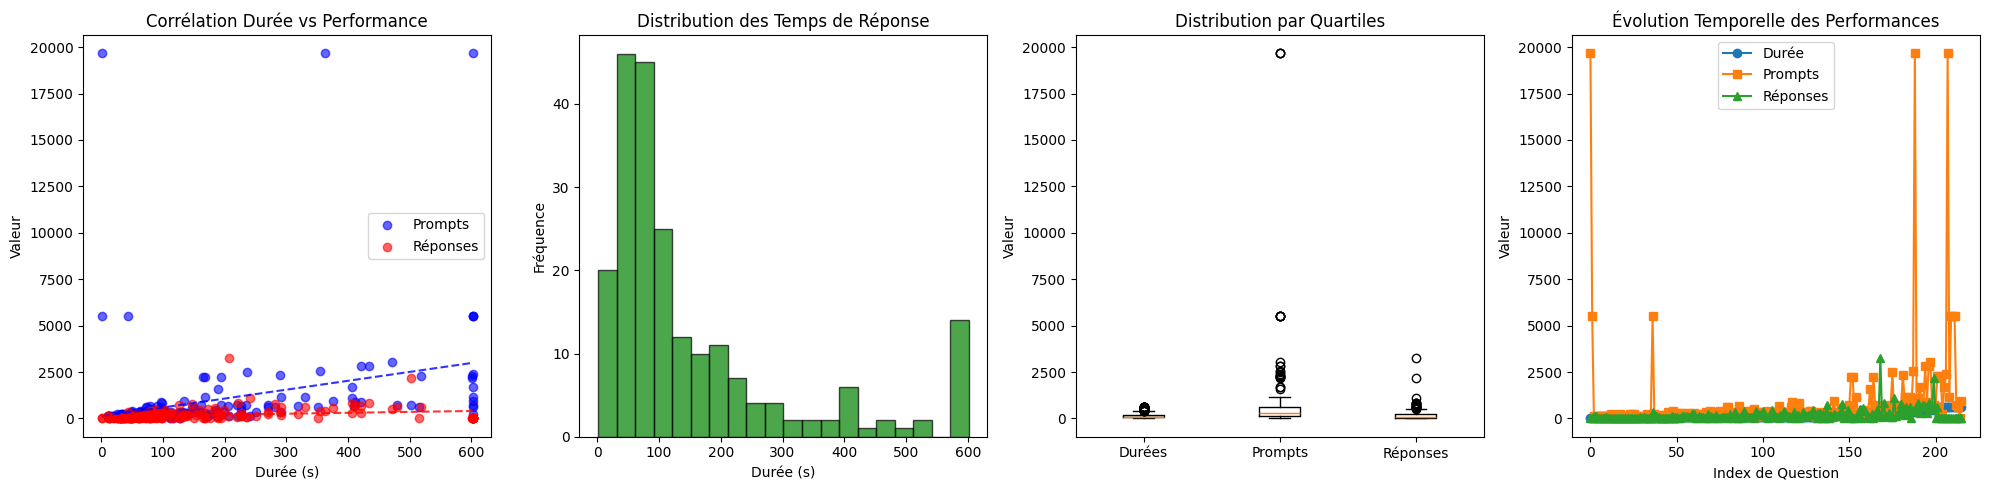

In [16]:
def str_to_seconds(t):
    """Convertit un temps 'HH:MM:SS' en secondes (int)."""
    h, m, s = map(int, t.split(':'))
    return h * 3600 + m * 60 + s

# Conversion des durées texte en secondes
durees_sec = [str_to_seconds(d) for d in durees]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

# Scatter plot avec régression
ax1.scatter(durees_sec, prompts, alpha=0.6, color='blue', label='Prompts')
ax1.scatter(durees_sec, reponses, alpha=0.6, color='red', label='Réponses')

# Ligne de tendance
z1 = np.polyfit(durees_sec, prompts, 1)
p1 = np.poly1d(z1)
ax1.plot(durees_sec, p1(durees_sec), "b--", alpha=0.8)

z2 = np.polyfit(durees_sec, reponses, 1)
p2 = np.poly1d(z2)
ax1.plot(durees_sec, p2(durees_sec), "r--", alpha=0.8)

ax1.set_xlabel('Durée (s)')
ax1.set_ylabel('Valeur')
ax1.set_title('Corrélation Durée vs Performance')
ax1.legend()

# Histogramme des durées
ax2.hist(durees_sec, bins=20, alpha=0.7, color='green', edgecolor='black')
ax2.set_xlabel('Durée (s)')
ax2.set_ylabel('Fréquence')
ax2.set_title('Distribution des Temps de Réponse')

# Box plot par quartiles
data_for_box = [durees_sec, prompts, reponses]
ax3.boxplot(data_for_box, tick_labels=['Durées', 'Prompts', 'Réponses'])
ax3.set_ylabel('Valeur')
ax3.set_title('Distribution par Quartiles')

# Graphique de performance temporelle
ax4.plot(range(len(durees_sec)), durees_sec, marker='o', label='Durée')
ax4.plot(range(len(prompts)), prompts, marker='s', label='Prompts')
ax4.plot(range(len(reponses)), reponses, marker='^', label='Réponses')
ax4.set_xlabel('Index de Question')
ax4.set_ylabel('Valeur')
ax4.set_title('Évolution Temporelle des Performances')
ax4.legend()

plt.tight_layout()
plt.show()

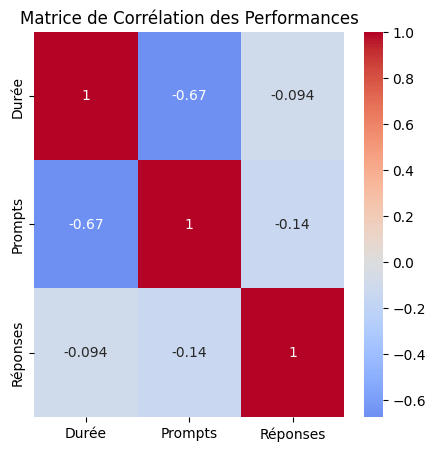

In [17]:
# Matrice de corrélation
fig, ax = plt.subplots(figsize=(5, 5))

durees_sec = [str_to_seconds(d) for d in durees]

data_corr = pd.DataFrame({
    'Durée':  durees_sec[:13],
    'Prompts':   prompts[:13],
    'Réponses': reponses[:13]
})

correlation_matrix = data_corr.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=ax)
ax.set_title('Matrice de Corrélation des Performances')
plt.show()

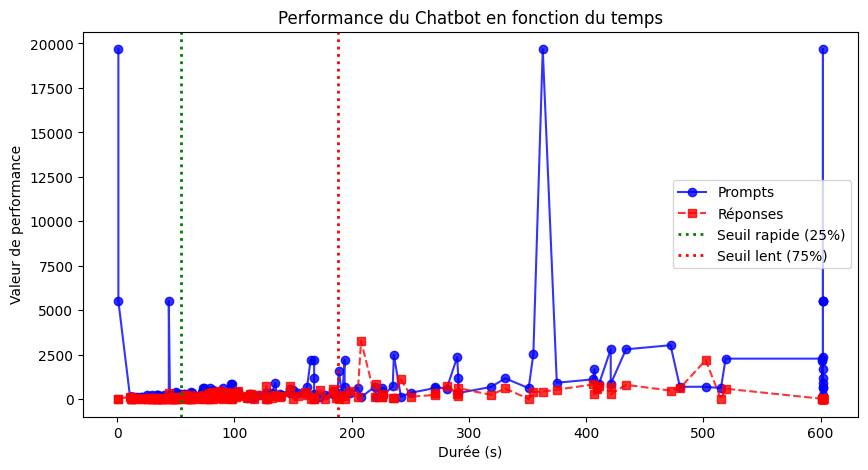

In [18]:
# Performance en fonction du temps
fig, ax = plt.subplots(figsize=(10, 5))

# Affichage des courbes de performance en fonction du temps
ax.plot(durees_sec, prompts, marker='o', linestyle='-', alpha=0.8, color='blue', label='Prompts')
ax.plot(durees_sec, reponses, marker='s', linestyle='--', alpha=0.8, color='red', label='Réponses')

# Calcul des seuils et visualisation avec des lignes horizontales
seuil_rapide = np.percentile(durees_sec, 25)
seuil_lent = np.percentile(durees_sec, 75)
ax.axvline(seuil_rapide, color='green', linestyle=':', linewidth=2, label='Seuil rapide (25%)')
ax.axvline(seuil_lent, color='red', linestyle=':', linewidth=2, label='Seuil lent (75%)')

ax.set_xlabel('Durée (s)')
ax.set_ylabel('Valeur de performance')
ax.set_title('Performance du Chatbot en fonction du temps')
ax.legend()

plt.show()

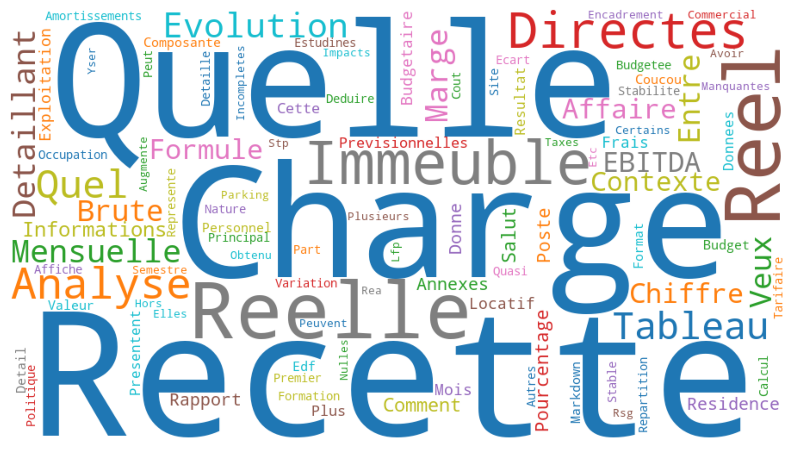

In [19]:
# Nuage de mots
questions = [i["labelMotCle"] for i in res]
all_questions = ' '.join(questions)
wc = WordCloud(
            width=900,
            height=500,
            background_color='white',
            max_words=100,
            colormap='tab10',
            contour_color='steelblue',
            contour_width=1,
            prefer_horizontal=0.7,
            random_state=42,
            collocations=False
        ).generate(all_questions)

plt.figure(figsize=(10, 8))
plt.imshow(wc, interpolation='kaiser')
plt.axis('off')
plt.show()

---

# Parsing V2

sp_simBudValueOne

In [67]:
from app.services.functions import execute_sp
import unicodedata
import difflib
import spacy
import re

In [68]:
res = await execute_sp(
    "dbo.sp_simBudLines",
    {
        "user_fk": 8,
		"form_fk": 167,
        "line_fk": 0,
		"choix": 0,
		"isVisible": 1
    }
)

In [69]:
def create_simplified_hierarchy(flat_data: (list[dict])):
    """
    Generates a hierarchy from a flat list, keeping only the 'label' and 'children' fields for each node.

    Args:
        flat_data (list[dict]): List of dictionaries describing flat nodes.
            Each dict must have at least 'line_id', 'parent_fk', 'label'.

    Returns:
        list[dict]: Hierarchical tree of simplified nodes with only 'label' and 'children'.
    """
    index_by_id = {}
    children_by_parent = {}
    roots = []

    for item in flat_data:
        node = item.copy()
        current_id = node['line_id']
        parent_id = node['parent_fk'] if node['parent_fk'] != 'NULL' else None

        index_by_id[current_id] = node

        if parent_id is None:
            roots.append(current_id)
        else:
            children_by_parent.setdefault(parent_id, []).append(current_id)

    def build_simplified_node(node_id):
        """Recursively constructs a simplified node from its ID."""
        node_label = index_by_id[node_id]['label']
        children_ids = children_by_parent.get(node_id, [])
        children_list = [build_simplified_node(child_id) for child_id in children_ids]
        return {'label': node_label, 'children': children_list}

    return [build_simplified_node(root_id) for root_id in roots]

simple_dict = create_simplified_hierarchy(res)
simple_dict

[{'label': 'RECETTES',
  'children': [{'label': 'Loyers logements et parkings HT',
    'children': [{'label': 'CA Locatif Estudines', 'children': []},
     {'label': 'CA Locatif Apparthotels', 'children': []},
     {'label': 'CA Locatif Activiales', 'children': []},
     {'label': 'CA Locatif Parkings', 'children': []},
     {'label': 'CA Des Commerces', 'children': []}]},
   {'label': 'RECETTES ANNEXES',
    'children': [{'label': 'CA petits déjeuners',
      'children': [{'label': 'Recettes petits-déjeuners', 'children': []},
       {'label': 'CA petits déjeuners', 'children': []}]},
     {'label': 'CA Frais locatif', 'children': []},
     {'label': 'CA Séminaire (loc. de salle)', 'children': []},
     {'label': 'CA Restauration',
      'children': [{'label': 'Restaurant', 'children': []},
       {'label': 'Mini market', 'children': []},
       {'label': 'Bar', 'children': []},
       {'label': 'Room service / Soirée étape', 'children': []}]},
     {'label': 'CA Laverie-Ménage',
    

In [70]:
len(simple_dict)

14

In [71]:
labels = [i["label"] for i in res]
labels

['RECETTES',
 'Loyers logements et parkings HT',
 'CA Locatif Estudines',
 'CA Locatif Apparthotels',
 'CA Locatif Activiales',
 'CA Locatif Parkings',
 'CA Des Commerces',
 'RECETTES ANNEXES',
 'CA petits déjeuners',
 'Recettes petits-déjeuners',
 'CA petits déjeuners',
 'CA Frais locatif',
 'CA Séminaire (loc. de salle)',
 'CA Restauration',
 'Restaurant',
 'Mini market',
 'Bar',
 'Room service / Soirée étape',
 'CA Laverie-Ménage',
 'Location de linge',
 'Laverie',
 'Pressing',
 'Ménage supplémentaire',
 'CA Billeterie',
 'CA Taxe de séjours',
 'CA Divers',
 "Subvention d'exploitation (Rbst format°)",
 'CA Communication',
 'Produits Divers',
 'Charges de copro récupérables',
 'CA Spa',
 'CA Boutique SPA',
 'CA Soins SPA',
 'CA Annexes SPA',
 'Commission Agence TO',
 'IMPAYES',
 'Impayés locataires',
 'Impayés Apparthotels',
 'Impayés Activiales',
 "CHARGES D'IMMEUBLE DIRECTES",
 'FRAIS DE PERSONNEL',
 'Salaires',
 'Charges sur salaires',
 'Prime',
 "Remboursement de l'Etat",
 'Logem

### v1

In [18]:
def trouver_meilleur_libelle(
    requete_utilisateur: str,
    liste_libelles: list,
    seuil_sim: float = 0.6
) -> str | None:
    """
    Recherche le libellé dans la liste qui correspond le plus à la requête de l'utilisateur,
    en utilisant la normalisation et une mesure de similarité robuste.

    - Utilise difflib et une mesure de similarité basée sur des tokens pour gérer les variations.
    - Améliore la normalisation et donne plus d'informations sur la correspondance.
    """

    def normaliser_texte_adv(texte):
        # Lower, strip, sans accents, retire la ponctuation
        texte = texte.lower().strip()
        texte = ''.join(
            c for c in unicodedata.normalize('NFD', texte)
            if unicodedata.category(c) != 'Mn'
        )
        import re
        texte = re.sub(r'[^\w\s]', '', texte)
        return texte

    # Normalise la requête utilisateur en version avancée
    requete_normalisee = normaliser_texte_adv(requete_utilisateur)

    def token_set_ratio(a, b):
        """Renvoie un score (0 à 1) basé sur l'intersection/union des tokens, à la manière de fuzz.token_set_ratio."""
        set_a = set(a.split())
        set_b = set(b.split())
        if not set_a or not set_b:
            return 0.0
        intersection = set_a & set_b
        union = set_a | set_b
        # Ajoute un bonus selon la proportion de tokens partagés
        if not union:
            return 0.0
        ratio = len(intersection) / len(union)
        return ratio

    meilleur_match = None
    meilleur_score = 0.0

    for libelle in liste_libelles:
        libelle_normalise = normaliser_texte_adv(libelle)
        # Combinaison: ratio de difflib et ratio par tokens
        diff_score = difflib.SequenceMatcher(None, requete_normalisee, libelle_normalise).ratio()
        tokens_score = token_set_ratio(requete_normalisee, libelle_normalise)
        # pondération (à ajuster selon usgae)
        score = 0.8 * diff_score + 0.2 * tokens_score

        if score > meilleur_score:
            meilleur_score = score
            meilleur_match = libelle

    if meilleur_score >= seuil_sim:
        return meilleur_match
    else:
        print(
            f"[NO MATCH] Aucun libellé n'a atteint le seuil de {seuil_sim}. "
            f"Meilleur: '{meilleur_match}' (score: {meilleur_score:.2f})"
        )
        return None

In [19]:
requete_1 = "entre RECETTES et CHARGES D'IMMEUBLE directes"

match_1 = trouver_meilleur_libelle(requete_1, labels, seuil_sim=.6) 

print(f"Résultat pour '{requete_1}': {match_1}")

Résultat pour 'entre RECETTES et CHARGES D'IMMEUBLE directes': CHARGES D'IMMEUBLE DIRECTES


In [20]:
from spacy.tokens import Doc

def extraire_entites(requete_utilisateur: str, doc: Doc):
    ENT_LABELS = {"MISC", "ORG", "PRODUCT", "PER", "LOC"}

    fragments = [ent.text.strip() for ent in doc.ents if ent.label_ in ENT_LABELS]

    if not fragments:
        texte = re.sub(r'\s+', ' ', requete_utilisateur.strip())

        match = re.search(r"(?:entre|de)\s+(.*?)\s+(?:et|à)\s+(.*)", texte, flags=re.IGNORECASE)
        if match:
            fragments = [match.group(1).strip(), match.group(2).strip()]
        else:
            fragments = re.split(r'\b(?:et|ou|sauf|,|;|avec)\b', texte, flags=re.IGNORECASE)
            fragments = [frag.strip() for frag in fragments if frag.strip()]

    return fragments

In [21]:
def extraire_labels_multiples(requete_utilisateur: str, vos_libelles_exacts: list) -> list:
    """
    Isole et fait correspondre plusieurs labels à partir d'une requête complexe.
    """

    # Utilise un modèle NER pour extraire des entités candidates
    import spacy
    nlp = spacy.load("fr_core_news_md")

    doc = nlp(requete_utilisateur)
    fragments = [ent.text for ent in doc.ents if ent.label_ in {"MISC", "ORG", "PRODUCT", "PER", "LOC"}]
    # Si aucune entité NER détectée, fallback découpage simple
    if not fragments:
        fragments = re.split(r'\b(?:et|ou|sauf|,)\b', requete_utilisateur, flags=re.IGNORECASE)
    
    labels_trouves = []
    
    for fragment in fragments:
        fragment_nettoye = fragment.strip()
        if not fragment_nettoye:
            continue
            
        # 2. Appel de la fonction sémantique pour chaque fragment
        match_exact = trouver_meilleur_libelle(
            fragment_nettoye,
            vos_libelles_exacts,
            seuil_sim=0.6
        )
        
        if match_exact and match_exact not in labels_trouves:
            labels_trouves.append(match_exact)
            
    return labels_trouves, fragments

In [22]:
requete_exemple = "entre RECETTES et CHARGES D'IMMEUBLE directes"
labels_trouves, fragments = extraire_labels_multiples(requete_exemple, labels)
print(fragments)
print(labels_trouves)

["CHARGES D'IMMEUBLE"]
["Charges d'immeuble"]


---

In [26]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('all-mpnet-base-v2')

REFERENCE_EMBEDDINGS = model.encode(labels)

d:\API Chatbot\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
from sklearn.metrics.pairwise import cosine_similarity
from numpy import array as np_array  # ou simplement from numpy import array

def trouver_meilleur_libelle_semantique(
    requete_utilisateur: str,
    vos_libelles_exacts: list,          # Liste des libellés de référence
    reference_embeddings: 'np_array',   # Vecteurs pré-calculés des libellés
    model: 'SentenceTransformer',       # Le modèle d'embeddings chargé
    seuil_sim: float = 0.6              # Seuil de similarité cosinus (typiquement entre 0.6 et 0.8)
) -> str | None:
    """
    Trouve le libellé exact le plus proche sémantiquement de la requête utilisateur.
    """

    # 1. Calculer l'embedding de la requête utilisateur
    requete_embedding = model.encode([requete_utilisateur])

    # 2. Calculer la similarité cosinus entre la requête et tous les libellés de référence
    scores_sim = cosine_similarity(requete_embedding, reference_embeddings)[0]

    # 3. Trouver l'index du score maximum
    meilleur_index = scores_sim.argmax()
    meilleur_score = scores_sim[meilleur_index]
    meilleur_match = vos_libelles_exacts[meilleur_index]

    if meilleur_score >= seuil_sim:
        print(f"[Analyse Sémantique] Score: {meilleur_score:.2f} | Match: '{meilleur_match}'")
        return meilleur_match
    else:
        print(f"[Analyse Sémantique] Aucun libellé n'a atteint le seuil de {seuil_sim}. Meilleur score: {meilleur_score:.2f} pour {meilleur_match}")
        return None

In [24]:
def extraire_labels_multiples(requete_utilisateur: str, vos_libelles_exacts: list) -> list:
    """
    Isole et fait correspondre plusieurs labels à partir d'une requête complexe.
    """

    # Utilise un modèle NER pour extraire des entités candidates
    import spacy
    nlp = spacy.load("fr_core_news_md")

    doc = nlp(requete_utilisateur)
    fragments = [ent.text for ent in doc.ents if ent.label_ in {"MISC", "ORG", "PRODUCT", "PER", "LOC"}]
    # Si aucune entité NER détectée, fallback découpage simple
    if not fragments:
        fragments = re.split(r'\b(?:et|ou|sauf|,)\b', requete_utilisateur, flags=re.IGNORECASE)
    
    labels_trouves = []
    
    for fragment in fragments:
        fragment_nettoye = fragment.strip()
        if not fragment_nettoye:
            continue
            
        # Appel de la fonction sémantique pour chaque fragment
        match_exact = trouver_meilleur_libelle_semantique(
            fragment_nettoye,
            vos_libelles_exacts,
            REFERENCE_EMBEDDINGS, # Les vecteurs pré-calculés
            model,                # Le modèle d'embeddings
            seuil_sim=0.65
        )
        
        if match_exact and match_exact not in labels_trouves:
            labels_trouves.append(match_exact)
            
    return labels_trouves

In [27]:
requete_exemple = "entre RECETTES et CHARGES D'IMMEUBLE directes"
labels_trouves = extraire_labels_multiples(requete_exemple, labels)
print(labels_trouves)

[Analyse Sémantique] Score: 1.00 | Match: 'Charges d'immeuble'
["Charges d'immeuble"]


In [30]:
requete_exemple = "entre RECETTES et CHARGES D'IMMEUBLE directes"
match_exact = trouver_meilleur_libelle_semantique(
    requete_exemple,
    labels,
    REFERENCE_EMBEDDINGS, # Les vecteurs pré-calculés
    model,                # Le modèle d'embeddings
    seuil_sim=0.60
)
match_exact

[Analyse Sémantique] Score: 0.80 | Match: 'CHARGES D'IMMEUBLE DIRECTES'


"CHARGES D'IMMEUBLE DIRECTES"

In [ ]:
import re
import unicodedata
from typing import List, Dict, Tuple, Any

# spaCy for phrase matching
import spacy
from spacy.matcher import PhraseMatcher

# RapidFuzz for fuzzy matching
from rapidfuzz import fuzz, process

# Embeddings
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# --------- Utilities ----------
def normalize_text(text: str) -> str:
    # lowercase, remove accents, collapse spaces
    text = text.lower().strip()
    text = ''.join(ch for ch in unicodedata.normalize('NFD', text)
                    if unicodedata.category(ch) != 'Mn')
    text = re.sub(r'\s+', ' ', text)
    return text

# --------- Phrase matcher (spaCy) ----------
def build_phrase_matcher(nlp, labels: List[str]):
    matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
    patterns = [nlp.make_doc(label) for label in labels]
    matcher.add("LABELS", patterns)
    return matcher

def phrase_match_labels(nlp, matcher, text: str) -> List[Tuple[str,int]]:
    doc = nlp(text)
    found = []
    for _, start, end in matcher(doc):
        span = doc[start:end].text
        found.append((span, start))
    # deduplicate keeping order
    seen = set(); out=[]
    for span, _ in found:
        if span not in seen:
            seen.add(span); out.append((span, 100))  # score 100 exact-ish
    return out

# --------- Fuzzy matching (RapidFuzz) ----------
def fuzzy_match_labels(text: str, labels: List[str], limit=10, score_cutoff=75) -> List[Tuple[str,int]]:
    # use token_sort_ratio for better multi-word matching
    results = []
    for label in labels:
        score = fuzz.token_sort_ratio(label, text)
        if score >= score_cutoff:
            results.append((label, int(score)))
    return sorted(results, key=lambda x: -x[1])

# --------- Embedding similarity ----------
class EmbeddingMatcher:
    def __init__(self, model_name="paraphrase-multilingual-MiniLM-L12-v2", labels=None):
        self.model = SentenceTransformer(model_name)
        self.labels = labels or []
        if self.labels:
            self.label_emb = self.model.encode(self.labels, convert_to_numpy=True, normalize_embeddings=True)
        else:
            self.label_emb = None

    def set_labels(self, labels: List[str]):
        self.labels = labels
        self.label_emb = self.model.encode(self.labels, convert_to_numpy=True, normalize_embeddings=True)

    def match(self, text: str, top_k=5, sim_threshold=0.65) -> List[Tuple[str, float]]:
        if self.label_emb is None:
            self.set_labels(self.labels)
        emb = self.model.encode([text], convert_to_numpy=True, normalize_embeddings=True)[0]
        sims = cosine_similarity([emb], self.label_emb)[0]
        matches = []
        for idx, score in enumerate(sims):
            if score >= sim_threshold:
                matches.append((self.labels[idx], float(score)))
        return sorted(matches, key=lambda x: -x[1])

# --------- Combined detector ----------
def detect_labels(query: str, labels: List[str], nlp=None, emb_matcher: EmbeddingMatcher=None) -> List[Dict[str,Any]]:
    norm_q = normalize_text(query)
    # Build spaCy matcher if nlp passed
    phrase_results = []
    if nlp is not None:
        matcher = build_phrase_matcher(nlp, labels)
        phrase_results = phrase_match_labels(nlp, matcher, query)

    fuzzy_results = fuzzy_match_labels(norm_q, labels, score_cutoff=70)
    
    emb_results = []
    if emb_matcher is not None:
        emb_results = emb_matcher.match(norm_q, sim_threshold=0.62)

    # Combine: use dict to keep best score per label, and note method(s)
    combined = {}
    for lbl, score in phrase_results:
        lnorm = normalize_text(lbl)
        combined[lnorm] = {"label": lbl, "score": score, "methods": {"phrase": score}}
    for lbl, score in fuzzy_results:
        lnorm = normalize_text(lbl)
        entry = combined.get(lnorm, {"label": lbl, "score": 0, "methods": {}})
        if score > entry["score"]:
            entry["score"] = score
        entry["methods"]["fuzzy"] = score
        combined[lnorm] = entry
    for lbl, score in emb_results:
        lnorm = normalize_text(lbl)
        entry = combined.get(lnorm, {"label": lbl, "score": 0, "methods": {}})
        s = int(score*100)
        if s > entry["score"]:
            entry["score"] = s
        entry["methods"]["embedding"] = float(score)
        combined[lnorm] = entry

    # Return sorted by descending score
    out = sorted(combined.values(), key=lambda x: -x["score"])
    return out

# --------- Exemple d'utilisation ----------
query = "Je veux un comparatif entre RECETTES et CHARGES D'IMMEUBLE directes sur 2024"

# spaCy NLP (fr)
nlp = spacy.load("fr_core_news_md")
# Embedding matcher (multilingual)
emb = EmbeddingMatcher(labels=labels)

results = detect_labels(query, labels, nlp=nlp, emb_matcher=emb)
print(results)

[{'label': 'RECETTES', 'score': 100, 'methods': {'phrase': 100}}, {'label': "CHARGES D'IMMEUBLE", 'score': 100, 'methods': {'phrase': 100}}, {'label': "CHARGES D'IMMEUBLE directes", 'score': 100, 'methods': {'phrase': 100}}]


In [ ]:
import re
import unicodedata
from rapidfuzz import fuzz
import spacy

# --- Normalisation du texte ---
def normalize_text(text: str) -> str:
    text = text.lower().strip()
    text = ''.join(ch for ch in unicodedata.normalize('NFD', text)
                    if unicodedata.category(ch) != 'Mn')
    text = re.sub(r'\s+', ' ', text)
    return text

# --- Détection des labels dans une question ---
def detect_labels_in_query(query: str, labels: list, threshold: int = 55) -> list:
    """
    Renvoie uniquement les labels de la liste `labels` détectés dans la question `query`.
    - Recherche par correspondance exacte et fuzzy (similitude).
    """
    detected = []
    query_norm = normalize_text(query)

    for label in labels:
        label_norm = normalize_text(label)

        # correspondance exacte
        if label_norm in query_norm:
            detected.append(label)
            continue

        # sinon correspondance floue (utile pour variantes)
        score = fuzz.token_sort_ratio(label_norm, query_norm)
        if score >= threshold:
            detected.append(label)

    return list(dict.fromkeys(detected))  # suppression doublons

# --- Exemple d'utilisation ---
question = "entre recettes et charge d'immeuble sur 2024"

result = detect_labels_in_query(question, labels)
print(result)

['RECETTES', "CHARGES D'IMMEUBLE DIRECTES"]


In [ ]:
def get_children_by_label(data, target_label):
    """
    Recherche un label donné dans une structure arborescente (liste de dictionnaires
    imbriqués avec 'label' et 'children') et retourne la liste des labels de ses enfants.

    :param data: La liste des noeuds racine de la structure (votre liste principale).
    :param target_label: Le label (chaîne de caractères) dont on cherche les enfants.
    :return: Une liste de chaînes de caractères (les labels des enfants) ou None si le label n'est pas trouvé.
    """
    if not isinstance(data, list):
        return None

    for node in data:
        if node.get('label') == target_label:
            return [child.get('label') for child in node.get('children', [])]

        if node.get('children'):
            result = get_children_by_label(node['children'], target_label)
            
            if result is not None:
                return result
    
    return None

In [ ]:
label_cible_1 = "RECETTES"
enfants_1 = get_children_by_label(simple_dict, label_cible_1)
print(f"Enfants de '{label_cible_1}' :")
print(enfants_1)

label_cible_2 = "CA Restauration"
enfants_2 = get_children_by_label(simple_dict, label_cible_2)
print(f"\nEnfants de '{label_cible_2}' :")
print(enfants_2)

label_cible_3 = "CA Locatif Parkings"
enfants_3 = get_children_by_label(simple_dict, label_cible_3)
print(f"\nEnfants de '{label_cible_3}' :")
print(enfants_3)

label_cible_4 = "LABEL INEXISTANT"
enfants_4 = get_children_by_label(simple_dict, label_cible_4)
print(f"\nEnfants de '{label_cible_4}' :")
print(enfants_4)

Enfants de 'RECETTES' :
['Loyers logements et parkings HT', 'RECETTES ANNEXES', 'Commission Agence TO', 'IMPAYES']

Enfants de 'CA Restauration' :
['Restaurant', 'Mini market', 'Bar', 'Room service / Soirée étape']

Enfants de 'CA Locatif Parkings' :
[]

Enfants de 'LABEL INEXISTANT' :
None


In [50]:
get_children_by_label(simple_dict, "IMPAYES")

---

In [72]:
def generate_hierarchy_codes(data, parent_code=""):
    """
    Génère les codes hiérarchiques dans l'arbre (modification In-Place).
    """
    if not isinstance(data, list):
        return []

    for index, node in enumerate(data):
        current_level_num = index + 1
        new_code = f"{parent_code}{current_level_num}."
        node['code'] = new_code
        if 'children' in node and node['children']:
            generate_hierarchy_codes(node['children'], new_code)
    return data

def extract_flat_hierarchy_list(data):
    """
    Extrait tous les labels et leurs codes dans une liste plate.
    """
    flat_list = []
    if not isinstance(data, list):
        return flat_list
    for node in data:
        flat_list.append({
            'label': node.get('label'),
            'code': node.get('code')
        })
        if 'children' in node and node['children']:
            flat_list.extend(extract_flat_hierarchy_list(node['children']))
    return flat_list

In [73]:
df = pd.read_csv(r"D:\API Chatbot\tests\data.csv")
coded_tree = generate_hierarchy_codes(simple_dict)
hierarchy_list = extract_flat_hierarchy_list(coded_tree)
mapping_dict = {item['label']: item['code'] for item in hierarchy_list}

In [74]:
df['Code Hiérarchique'] = df['Lignes'].map(mapping_dict)

In [ ]:
print("Résultat du mapping : Colonne 'Lignes' avec le nouveau 'Code Hiérarchique'\n")
print(df[['Lignes', 'Code Hiérarchique', 'Montant']].head(10))

print(f"\nTotal des lignes traitées : {len(df)}")
print(f"Nombre de lignes non mappées : {df['Code Hiérarchique'].isna().sum()}")

Résultat du mapping : Colonne 'Lignes' avec le nouveau 'Code Hiérarchique'

                   Lignes Code Hiérarchique  Montant
0  % DES RECETTES TOTALES               10.    -0.77
1  % DES RECETTES TOTALES               10.    10.08
2  % DES RECETTES TOTALES               10.     1.12
3  % DES RECETTES TOTALES               10.    70.51
4  % DES RECETTES TOTALES               10.     0.78
5  % DES RECETTES TOTALES               10.    -3.83
6  % DES RECETTES TOTALES               10.    -0.14
7  % DES RECETTES TOTALES               10.      NaN
8  % DES RECETTES TOTALES               10.    -1.37
9  % DES RECETTES TOTALES               10.    19.34

Total des lignes traitées : 5146
Nombre de lignes non mappées : 109


In [79]:
print(df[['Code Hiérarchique', 'Lignes']].drop_duplicates().sort_values('Code Hiérarchique').head(50))

     Code Hiérarchique                                             Lignes
4388                1.                                           RECETTES
3193              1.1.                    Loyers logements et parkings HT
913             1.1.1.                               CA Locatif Estudines
969             1.1.4.                                CA Locatif Parkings
4444              1.2.                                   RECETTES ANNEXES
1093           1.2.12.                      Charges de copro récupérables
804             1.2.2.                                   CA Frais locatif
860             1.2.5.                                  CA Laverie-Ménage
2986          1.2.5.2.                                            Laverie
750             1.2.8.                                          CA Divers
1307              1.3.                               Commission Agence TO
2647              1.4.                                            IMPAYES
2682            1.4.1.                

In [25]:
from app.services.functions import count_tokens
t = """
| Code Hiérarchique   | Lignes                                       |          Montant |
|:--------------------|:---------------------------------------------|-----------------:|
| 2.                  | CHARGES D'IMMEUBLE DIRECTES                  | 645225           |
| 2.1.                | FRAIS DE PERSONNEL                           | 196299           |
| 2.2.                | IMPOTS et TAXES DIVERSES                     |   5653.15        |
| 2.3.                | ENERGIE                                      | 269587           |
| 2.4.                | CONTRATS DE MAINTENANCE                      |  67030.2         |
| 2.6.                | REMISE EN ETAT PARTIES PRIVATIVES            |  21993.8         |
| 2.7.                | REMISE EN ETAT PARTIES COMMUNES              |  25192           |
| 2.8.                | LINGE ET BLANCHISSAGE                        |   2067.95        |
| 2.9.                | FOURNITURES D'EXPLOITATION                   |   7052.46        |
| 2.10.               | ACHAT ALIMENTAIRE PDJ                        |      0           |
| 2.12.               | LOCATIONS, HONORAIRES, SACEM ET TV           |  12855.1         |
| 2.13.               | DEPLACEMENT ET MISSION                       |   1603.15        |
| 2.14.               | PUBLICITE                                    |   2506.49        |
| 2.15.               | Publicité Internet                           |   4451.7         |
| 2.16.               | FOURNITURES ADMINISTRATIVES                  |   1283.22        |
| 2.17.               | TELEPHONIE - INTERNET - INFORMATIQUE         |  27650.3         |
| 5.                  | Total 1                                      |      1.1238e+06  |
| 5.1.                | AMORTISSEMENT et CREDIT BAIL                 |  23186.3         |
| 5.2.                | LOYERS REVERSES PROPRIETAIRES                | 905812           |
| 5.3.                | GROS TRAVAUX                                 |   3770.7         |
| 5.4.                | INCIDENCE T.V.A                              | 165628           |
| 5.5.                | CET (ex Taxe Pro)                            |  25401.8         |
| 8.                  | Total 2                                      |  92874.4         |
| 8.1.                | PRESTATIONS INTERNES (Y/C Honoraires syndic) |  56234.3         |
| 8.2.                | FRAIS DES SOCIETES                           |  11107.9         |
| 8.3.                | HONORAIRES SYNDIC                            |  25532.2         |
| 13.                 | CAPEX                                        |  19270.4         |
"""

t = """
| Code Hiérarchique   | Lignes                                       |   Année | Contexte   |          Montant |
|:--------------------|:---------------------------------------------|--------:|:-----------|-----------------:|
| 2.                  | CHARGES D'IMMEUBLE DIRECTES                  |    2024 | R          | 663916           |
| 2.1.                | FRAIS DE PERSONNEL                           |    2024 | R          | 168150           |
| 2.2.                | IMPOTS et TAXES DIVERSES                     |    2024 | R          |   5502           |
| 2.3.                | ENERGIE                                      |    2024 | R          | 339699           |
| 2.4.                | CONTRATS DE MAINTENANCE                      |    2024 | R          |  48597           |
| 2.6.                | REMISE EN ETAT PARTIES PRIVATIVES            |    2024 | R          |  32530           |
| 2.7.                | REMISE EN ETAT PARTIES COMMUNES              |    2024 | R          |  24997.7         |
| 2.8.                | LINGE ET BLANCHISSAGE                        |    2024 | R          |   3350.26        |
| 2.9.                | FOURNITURES D'EXPLOITATION                   |    2024 | R          |   3021.56        |
| 2.10.               | ACHAT ALIMENTAIRE PDJ                        |    2024 | R          |      0           |
| 2.12.               | LOCATIONS, HONORAIRES, SACEM ET TV           |    2024 | R          |   4647.13        |
| 2.13.               | DEPLACEMENT ET MISSION                       |    2024 | R          |   1120.43        |
| 2.14.               | PUBLICITE                                    |    2024 | R          |   3010.81        |
| 2.15.               | Publicité Internet                           |    2024 | R          |   3063.22        |
| 2.16.               | FOURNITURES ADMINISTRATIVES                  |    2024 | R          |    825.93        |
| 2.17.               | TELEPHONIE - INTERNET - INFORMATIQUE         |    2024 | R          |  25400.7         |
| 5.                  | Total 1                                      |    2024 | R          |      1.08831e+06 |
| 5.1.                | AMORTISSEMENT et CREDIT BAIL                 |    2024 | R          |  28094.8         |
| 5.2.                | LOYERS REVERSES PROPRIETAIRES                |    2024 | R          | 882289           |
| 5.4.                | INCIDENCE T.V.A                              |    2024 | R          | 160708           |
| 5.5.                | CET (ex Taxe Pro)                            |    2024 | R          |  17219.2         |
| 8.                  | Total 2                                      |    2024 | R          | 216976           |
| 8.1.                | PRESTATIONS INTERNES (Y/C Honoraires syndic) |    2024 | R          | 180184           |
| 8.2.                | FRAIS DES SOCIETES                           |    2024 | R          |  11449.3         |
| 8.3.                | HONORAIRES SYNDIC                            |    2024 | R          |  25342.2         |
| 13.                 | CAPEX                                        |    2024 | R          |  15963.8         |
"""
count_tokens(t)

580